### Importing libs

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
from numba import jit

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from scipy.integrate import solve_ivp
from scipy import optimize
from scipy.integrate import simps

import seaborn as sns
import arviz as az
from arviz.utils import Numba

import pymc3 as pm
import theano
import theano.tensor as t
from scipy.stats import gaussian_kde
from tqdm import tqdm, trange

import matplotlib.patches as mpatches
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

from data_loading import LoadData
from proj_consts import ProjectConsts

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Graphics font properties

In [2]:
fontsize = 9

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": fontsize,
})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": fontsize,
})

### Specifying colors

In [3]:
original_data_color="C0"
reg_data_color="C1"
infected_color="C3"
dead_color="C2"

### Setting seed

In [4]:
seed = 12345

### Parameters to run

In [5]:
num_days_data = 210
num_days_prediction = 14
target_population = ProjectConsts.RJ_STATE_POPULATION

OUTPUT_PATH = "./Results"

data_types = np.array(["original", "reg"])
run_opt = False
run_opt_bayes = False
run_opt_var = False

calibration_variable_names = [r"$\beta$", r"$\omega$", r"$d_P$", r"$E(0)$", r"$\sigma$"]
draws = 3000
percentile_cut = 2.5

min_calibration_data = 60
max_calibration_data = num_days_data - num_days_prediction
step_calibration_data = 1

### Retrieving data

In [2]:
df_brazil_state_cases = LoadData.getBrazilDataFrame()
rj_state_cases = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, "RJ")
rj_state_cases = rj_state_cases.head(num_days_data)

data_time = np.array(rj_state_cases.day.values.astype(np.float64))
data_time = data_time - data_time[0]

infected_individuals = rj_state_cases.infected.values.astype(np.float64)
dead_individuals = np.diff(rj_state_cases.dead.values.astype(np.float64))
dead_individuals = np.insert(dead_individuals, 0, dead_individuals[0])

original_data = np.array([infected_individuals, dead_individuals])

data_dates = rj_state_cases.date.values
data_dates = [date.strftime("%d/%m/%y") for date in data_dates]

NameError: name 'LoadData' is not defined

### Regularization of data

In [7]:
reg_data = np.empty_like(original_data)
reg_data_stdev = np.empty([4, data_time.size], dtype=np.float64)
for i, data in enumerate(original_data):
    # Scaling data
    if i == 0:
        scale_const = 1
    elif i == 1:
        scale_const = 1
    scale_factor = data[-1] / scale_const
    scaled_data = data

    # Defining the kernel
    kernel = RBF()

    # Creating GP regressor
    if i == 0:
        model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=10, normalize_y=False)
    elif i == 1:
        model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=17, normalize_y=False)

    # Training the model
    model.fit(data_time.reshape(-1, 1), scaled_data)

    # Results
    target_pred = model.predict(data_time.reshape(-1, 1), return_std=True)

    # Standard deviation
    reg_data_stdev[2 * i, :] = target_pred[0] - 2 * target_pred[0] * target_pred[1]
    reg_data_stdev[2 * i, np.where(reg_data_stdev[2 * i, :] < 0)] = 0
    reg_data_stdev[(2 * i) + 1, :] = target_pred[0] + 2 * target_pred[0] * target_pred[1]
    reg_data_stdev[(2 * i) + 1, np.where(reg_data_stdev[(2 * i) + 1, :] < 0)] = 0

    # Saving rescaled regularized data
    reg_data[i,:] = target_pred[0]
    reg_data[i, np.where(reg_data[i, :] < 0)] = 0

    print("\nLearned kernel: %s" % model.kernel_)


Learned kernel: RBF(length_scale=68.9)

Learned kernel: RBF(length_scale=50.2)


### Comparing original and regularized data

<IPython.core.display.Javascript object>


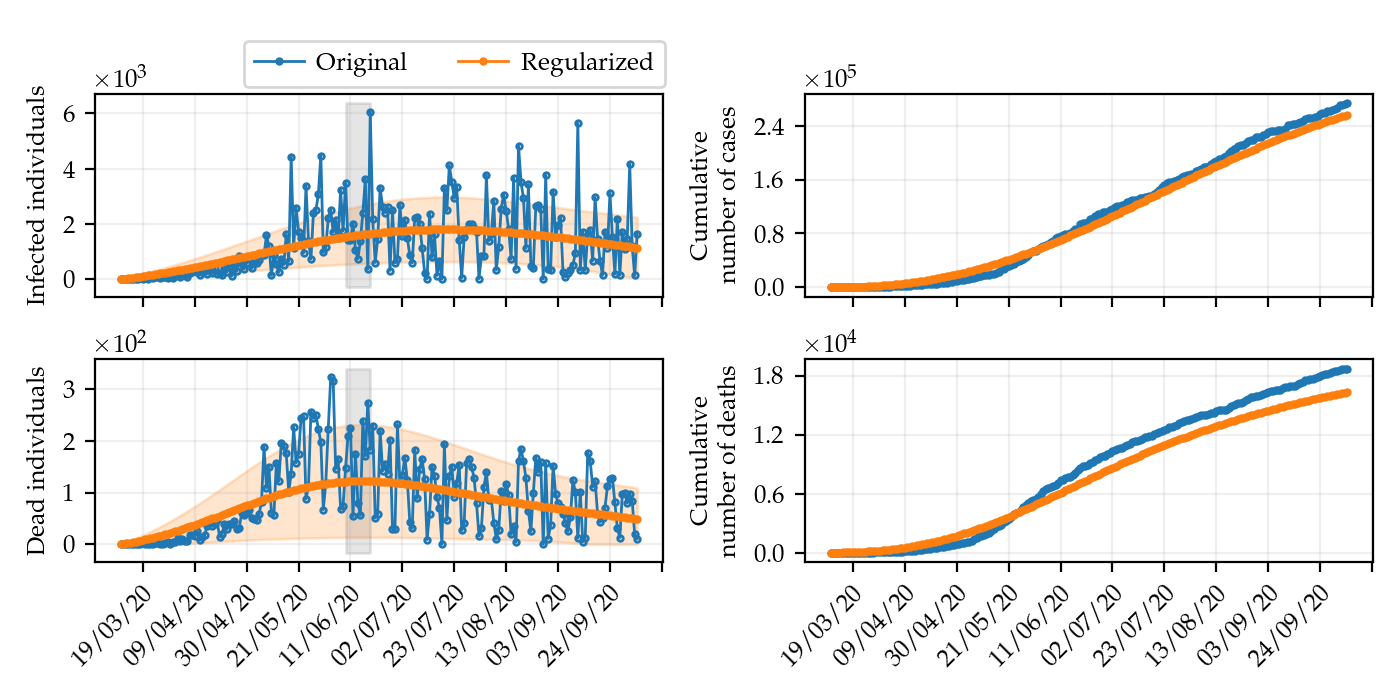

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(7, 3.5))

day_start_variability = min_calibration_data + 30 + 1
day_stop_variability = day_start_variability + 10
num_days_variability = day_stop_variability - day_start_variability + 1
array_variability_days = np.linspace(start=day_start_variability,
                                     stop=day_stop_variability,
                                     num=num_days_variability,
                                     endpoint=True)
array_variability_dates = np.array(data_dates)[array_variability_days.astype(int)]

###################
# Daily new cases #
###################

(ax[0, 0]).grid(alpha=0.2)

(ax[0, 0]).plot(
    data_dates,
    original_data[0],
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color=original_data_color,
    fillstyle="none",
    markeredgecolor=original_data_color,
    label="Original"
)

(ax[0, 0]).plot(
    data_dates,
    reg_data[0],
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color=reg_data_color,
    fillstyle="none",
    markeredgecolor=reg_data_color,
    label="Regularized"
)

(ax[0, 0]).fill_between(data_dates, reg_data_stdev[0], reg_data_stdev[1], color=reg_data_color, alpha=0.2)
(ax[0, 0]).fill_between(array_variability_dates,
                        np.repeat(((ax[0, 0]).get_ylim())[0], num_days_variability),
                        np.repeat(((ax[0, 0]).get_ylim())[1], num_days_variability),
                        color="C7",
                        alpha=0.2)

(ax[0, 0]).xaxis.set_major_locator(mdates.DayLocator(interval=21))
plt.setp((ax[0, 0]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

(ax[0, 0]).set_ylabel("Infected individuals")
(ax[0, 0]).legend(loc="upper right", fontsize=fontsize, ncol=2, handletextpad=0.5, bbox_to_anchor=(1.025,1.325))

(ax[0, 0]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(ax[0, 0]).yaxis.major.formatter._useMathText = True
(ax[0, 0]).yaxis.set_major_locator(plt.MaxNLocator(4))

####################
# Cumulative cases #
####################

(ax[0, 1]).grid(alpha=0.2)

(ax[0, 1]).plot(
    data_dates,
    np.cumsum(original_data[0]),
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color=original_data_color,
    fillstyle="none",
    markeredgecolor=original_data_color
)

(ax[0, 1]).plot(
    data_dates,
    np.cumsum(reg_data[0]),
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color=reg_data_color,
    fillstyle="none",
    markeredgecolor=reg_data_color
)

(ax[0, 1]).xaxis.set_major_locator(mdates.DayLocator(interval=21))
plt.setp((ax[0, 1]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

(ax[0, 1]).set_ylabel("Cumulative\nnumber of cases")

(ax[0, 1]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(ax[0, 1]).yaxis.major.formatter._useMathText = True
(ax[0, 1]).yaxis.set_major_locator(plt.MaxNLocator(4))

####################
# Daily new deaths #
####################

(ax[1, 0]).grid(alpha=0.2)

(ax[1, 0]).plot(
    data_dates,
    original_data[1],
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color=original_data_color,
    fillstyle="none",
    markeredgecolor=original_data_color
)

(ax[1, 0]).plot(
    data_dates,
    reg_data[1],
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color=reg_data_color,
    fillstyle="none",
    markeredgecolor=reg_data_color
)

(ax[1, 0]).fill_between(data_dates, reg_data_stdev[2], reg_data_stdev[3], color=reg_data_color, alpha=0.2)
(ax[1, 0]).fill_between(array_variability_dates,
                        np.repeat(((ax[1, 0]).get_ylim())[0], num_days_variability),
                        np.repeat(((ax[1, 0]).get_ylim())[1], num_days_variability),
                        color="C7",
                        alpha=0.2)

(ax[1, 0]).xaxis.set_major_locator(mdates.DayLocator(interval=21))
plt.setp((ax[1, 0]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

(ax[1, 0]).set_ylabel("Dead individuals")

(ax[1, 0]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(ax[1, 0]).yaxis.major.formatter._useMathText = True
(ax[1, 0]).yaxis.set_major_locator(plt.MaxNLocator(4))

#####################
# Cumulative deaths #
#####################

(ax[1, 1]).grid(alpha=0.2)

(ax[1, 1]).plot(
    data_dates,
    np.cumsum(original_data[1]),
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color=original_data_color,
    fillstyle="none",
    markeredgecolor=original_data_color
)

(ax[1, 1]).plot(
    data_dates,
    np.cumsum(reg_data[1]),
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color=reg_data_color,
    fillstyle="none",
    markeredgecolor=reg_data_color
)

(ax[1, 1]).xaxis.set_major_locator(mdates.DayLocator(interval=21))
plt.setp((ax[1, 1]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

(ax[1, 1]).set_ylabel("Cumulative\nnumber of deaths")

(ax[1, 1]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(ax[1, 1]).yaxis.major.formatter._useMathText = True
(ax[1, 1]).yaxis.set_major_locator(plt.MaxNLocator(4))

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "data_regularization" + ".pdf")

infected_original_limits = (ax[0, 0]).get_ylim()
dead_original_limits = (ax[1, 0]).get_ylim()

### Defining the model

In [13]:
@jit(nopython=True)
def seirpdq_model(
    t,
    X,
    beta,
    gamma_I,
    gamma_P,
    d_P,
    omega,
    rho,
    sigma,
    N=1,
):
    """
    SEIRPD-Q python implementation.
    """
    S, E, I, P, R, D, C = X
    S_prime = -beta / N * S * I - omega * S
    E_prime = beta / N * S * I - sigma * E - omega * E
    I_prime = sigma * rho * E - gamma_I * I - omega * I
    P_prime = sigma * (1 - rho) * E - d_P * P - gamma_P * P
    R_prime = gamma_I * I + gamma_P * P + omega * (S + E + I)
    D_prime = d_P * P
    C_prime = sigma * (1 - rho) * E
    return S_prime, E_prime, I_prime, P_prime, R_prime, D_prime, C_prime

### Defining the ODE solver

In [14]:
def seirpdq_ode_solver(
    y0,
    t_span,
    t_eval,
    beta,
    omega,
    d_P,
    gamma_P=1 / 16.7,
    gamma_I=1 / 16.7,
    rho=0.6,
    sigma=1 / 5.8,
    N=1,
):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seirpdq_model(
            t,
            y,
            beta=beta,
            gamma_I=gamma_I,
            gamma_P=gamma_P,
            d_P=d_P,
            omega=omega,
            rho=rho,
            sigma=sigma,
            N=N,
        ),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        method="LSODA",
    )

    return solution_ODE

### Defining problem wrapper

In [15]:
def seirpdq_least_squares_error_ode_y0(
    par, time_exp, f_exp, fitting_model, known_initial_conditions, total_population
):
    num_of_initial_conditions_to_fit = 1
    num_of_parameters = len(par) - num_of_initial_conditions_to_fit
    args, trial_initial_conditions = [
        par[:num_of_parameters],
        par[num_of_parameters:],
    ]
    E0 = trial_initial_conditions
    I0, P0, R0, D0, C0 = known_initial_conditions
    S0 = total_population - (E0 + I0 + P0 + R0 + D0)
    initial_conditions = [S0, E0, I0, P0, R0, D0, C0]

    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    num_of_qoi = len(f_exp1)

    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t

    # dead_individuals, infected_individuals, confirmed_cases, recovered_cases
    simulated_ode_solution = y_model.y
    (
        _,
        _,
        _,
        simulated_P,
        _,
        simulated_D,
        simulated_C,
    ) = simulated_ode_solution
    simulated_D = np.diff(simulated_D)
    simulated_D = np.insert(simulated_D, 0, simulated_D[0])

    first_term = np.sum((f_exp1 - simulated_P) ** 2.0)
    second_term = np.sum((f_exp2 - simulated_D) ** 2.0)

    objective_function = 1 / num_of_qoi * (first_term + second_term)

    return objective_function

### Defining calibration/validation ratio

In [16]:
min_calibration_data = 60
max_calibration_data = len(data_time) - num_days_prediction
step_calibration_data = 1

### Calculating the number of problems to be solved

In [17]:
n_runs = int(((max_calibration_data - min_calibration_data - 1) / step_calibration_data) + 1)

### Function for model simulation

In [18]:
def simulate_model(data_time, y0, pars):
    S0 = target_population - (pars[3] + y0[0] + y0[1] + y0[2] + y0[3])
    y0_sol = S0, pars[3], y0[0], y0[1], y0[2], y0[3], y0[4]

    t0 = float(data_time.min())
    tf = float(data_time.max())

    solution_ODE = seirpdq_ode_solver(
        y0_sol, (t0, tf), data_time, pars[0], pars[1], pars[2]
    )

    t_solution_ODE, y_solution_ODE = (
        solution_ODE.t,
        solution_ODE.y,
    )
    
    return y_solution_ODE

### Defining optimization algorithm search space

In [19]:
bounds_seirpdq = [
    (0, 1e-6),   # beta
    (0, 1.0),  # omega
    (0, 1.0),  # d_P
    (0, 10000),  # E0
]

### Solving the problem $ n_{\text{runs}} $ times

In [20]:
if run_opt == True:
    for data_type in data_types:
    
        beta_values = np.zeros(n_runs)
        omega_values = np.zeros(n_runs)
        d_P_values = np.zeros(n_runs)
        E0_values = np.zeros(n_runs)
        
        bounds = np.zeros_like(bounds_seirpdq, dtype=np.float64)
        x0 = np.array([3.2695e-8, 0.0137886, 0.0125293, 415.8004])
        
        if data_type == "original":
            I0, P0, R0, D0, C0 = (original_data[0, 0], original_data[0, 0], 0, original_data[1, 0], original_data[0, 0])
        elif data_type == "reg":
            I0, P0, R0, D0, C0 = (reg_data[0, 0], reg_data[0, 0], 0, reg_data[1, 0], reg_data[0, 0])

        y0_seirpdq = np.array([I0, P0, R0, D0, C0], dtype=np.float64)

        for p, num_data_calibration in enumerate(np.arange(min_calibration_data, max_calibration_data, step_calibration_data)):
            data_time_validation = data_time[num_data_calibration : (num_data_calibration + num_days_prediction)]
            validation_data = original_data[:, num_data_calibration : (num_data_calibration + num_days_prediction)]

            data_time_calibration = data_time[0 : num_data_calibration]
            if data_type == "original":
                calibration_data = original_data[:, 0 : num_data_calibration] # Using original data
            elif data_type == "reg":
                calibration_data = reg_data[:, 0 : num_data_calibration] # Using regularized dataset

            print("\nRun: %d/%d\n" %(p+1, n_runs))

            success_res = False
            while success_res == False:

                print(x0)

                result_NM = optimize.minimize(
                    seirpdq_least_squares_error_ode_y0,
                    x0=x0,
                    args=(
                        data_time_calibration,
                        calibration_data,
                        seirpdq_ode_solver,
                        y0_seirpdq,
                        target_population,
                    ),
                    method="Nelder-Mead",
                    options={"maxiter": 500},
                )
                                
                if result_NM.success == True and np.all(result_NM.x > 0):
                    sol_NM = result_NM.x
                    for k in range(len(x0)):
                        bounds[k] = (sol_NM[k] - 0.05 * sol_NM[k], sol_NM[k] + 0.05 * sol_NM[k])

                    result_DE = optimize.differential_evolution(
                        seirpdq_least_squares_error_ode_y0,
                        bounds=bounds,
                        args=(
                            data_time_calibration,
                            calibration_data,
                            seirpdq_ode_solver,
                            y0_seirpdq,
                            target_population,
                        ),
                        popsize=20,
                        strategy="best1bin",
                        tol=1e-6,
                        recombination=0.95,
                        mutation=0.6,
                        maxiter=1000,
                        polish=True,
                        init="latinhypercube",
                        disp=False,
                        seed=seed,
                        callback=None,
                        updating="deferred",
                        workers=-1,
                    )
                    success_res = result_DE.success

                else:
                    for i in range(len(bounds_seirpdq)):
                        sign = np.random.uniform(0, 0.01, 1)
                        shift = sign * x0[i]

                        if np.random.uniform(0, 1, 1) < 0.5:
                            x0[i] = x0[i] - shift
                        else:
                            x0[i] = x0[i] + shift

            print(result_DE)

            opt_pars = result_DE.x
            (
                beta_deterministic,
                omega_deterministic,
                d_P_deterministic,
                E0_deterministic
            ) = opt_pars

            beta_values[p] = beta_deterministic
            omega_values[p] = omega_deterministic
            d_P_values[p] = d_P_deterministic
            E0_values[p] = E0_deterministic

            y_solution_ODE = simulate_model(data_time, y0_seirpdq, opt_pars)

            (
                S_predict_seirpdq,
                E_predict_seirpdq,
                I_predict_seirpdq,
                P_predict_seirpdq,
                R_predict_seirpdq,
                D_predict_seirpdq,
                C_predict_seirpdq,
            ) = y_solution_ODE

            x0 = opt_pars
            for i in range(len(bounds_seirpdq)):
                sign = np.random.uniform(0, 0.01, 1)
                shift = sign * x0[i]

                if np.random.uniform(0, 1, 1) < 0.5:
                    x0[i] = x0[i] - shift
                else:
                    x0[i] = x0[i] + shift

        pd.DataFrame(beta_values).to_csv(f"{OUTPUT_PATH}/beta_{data_type}.csv")
        pd.DataFrame(omega_values).to_csv(f"{OUTPUT_PATH}/omega_{data_type}.csv")
        pd.DataFrame(d_P_values).to_csv(f"{OUTPUT_PATH}/d_P_{data_type}.csv")
        pd.DataFrame(E0_values).to_csv(f"{OUTPUT_PATH}/E0_{data_type}.csv")

### Loading optimal parameters

In [21]:
for data_type in data_types:
    if data_type == "original":
        beta_values_original = pd.read_csv(f"{OUTPUT_PATH}/beta_{data_type}.csv", sep=',', usecols=[1]).to_numpy().ravel()
        omega_values_original = pd.read_csv(f"{OUTPUT_PATH}/omega_{data_type}.csv", sep=',', usecols=[1]).to_numpy().ravel()
        d_P_values_original = pd.read_csv(f"{OUTPUT_PATH}/d_P_{data_type}.csv", sep=',', usecols=[1]).to_numpy().ravel()
        E0_values_original = pd.read_csv(f"{OUTPUT_PATH}/E0_{data_type}.csv", sep=',', usecols=[1]).to_numpy().ravel()
    elif data_type == "reg":
        beta_values_reg = pd.read_csv(f"{OUTPUT_PATH}/beta_{data_type}.csv", sep=',', usecols=[1]).to_numpy().ravel()
        omega_values_reg = pd.read_csv(f"{OUTPUT_PATH}/omega_{data_type}.csv", sep=',', usecols=[1]).to_numpy().ravel()
        d_P_values_reg = pd.read_csv(f"{OUTPUT_PATH}/d_P_{data_type}.csv", sep=',', usecols=[1]).to_numpy().ravel()
        E0_values_reg = pd.read_csv(f"{OUTPUT_PATH}/E0_{data_type}.csv", sep=',', usecols=[1]).to_numpy().ravel()

### Plotting optimal parameter values

<IPython.core.display.Javascript object>


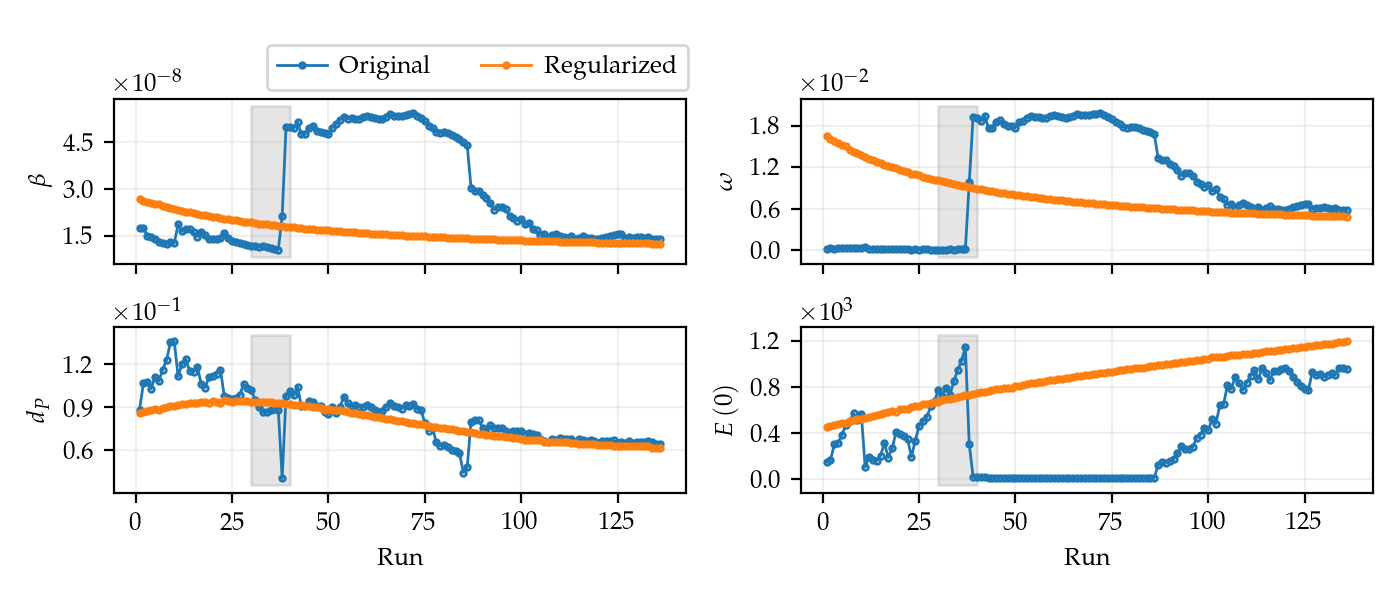

In [22]:
array_n_runs = np.linspace(1, n_runs, num=n_runs)

nrows = ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(7, 3))

start=30
stop=start+10
num=stop-start+1
array_variability_run = np.linspace(start=start, stop=stop, num=num, endpoint=True)

for i in range(nrows):
    for j in range(ncols):
        if i == 0:
            if j == 0:
                values_original=beta_values_original
                values_reg=beta_values_reg
                label=r"$\beta$"
            elif j == 1:
                values_original=omega_values_original
                values_reg=omega_values_reg
                label=r"$\omega$"
        elif i == 1:
            if j == 0:
                values_original=d_P_values_original
                values_reg=d_P_values_reg
                label=r"$d_P$"
            elif j == 1:
                values_original=E0_values_original
                values_reg=E0_values_reg
                label=r"$E\left( 0 \right)$"

        (ax[i, j]).grid(alpha=0.2)

        (ax[i, j]).plot(
            array_n_runs,
            values_original,
            marker="o",
            linestyle="-",
            markersize=2,
            linewidth=1,
            color=original_data_color,
            fillstyle="none",
            markeredgecolor=original_data_color,
            label="Original"
        )

        (ax[i, j]).plot(
            array_n_runs,
            values_reg,
            marker="o",
            linestyle="-",
            markersize=2,
            linewidth=1,
            color=reg_data_color,
            fillstyle="none",
            markeredgecolor=reg_data_color,
            label="Regularized"
        )

        (ax[i, j]).set_ylabel(label)
        if i == 0:
            if j == 0:
                (ax[i, j]).legend(loc="upper right",
                                  fontsize=fontsize,
                                  ncol=2,
                                  handletextpad=0.5,
                                  bbox_to_anchor=(1.025,1.4))
        elif i == 1:
                (ax[i, j]).set_xlabel("Run")

        (ax[i, j]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
        (ax[i, j]).yaxis.major.formatter._useMathText = True
        (ax[i, j]).yaxis.set_major_locator(plt.MaxNLocator(4))

        (ax[i, j]).fill_between(
            array_variability_run,
            np.repeat(((ax[i, j]).get_ylim())[0], num),
            np.repeat(((ax[i, j]).get_ylim())[1], num),
            color="C7",
            alpha=0.2,
        )

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "opt_params" + ".pdf")

### Calculating simulations using optimal parameters

In [23]:
infected_original = np.zeros((n_runs, data_time.size))
infected_original_cumsum = np.zeros((n_runs, data_time.size))
dead_original = np.zeros((n_runs, data_time.size))
dead_original_cumsum = np.zeros((n_runs, data_time.size))

infected_reg = np.zeros((n_runs, data_time.size))
infected_reg_cumsum = np.zeros((n_runs, data_time.size))
dead_reg = np.zeros((n_runs, data_time.size))
dead_reg_cumsum = np.zeros((n_runs, data_time.size))

for data_type in data_types:
    if data_type == "original":
        I0, P0, R0, D0, C0 = (original_data[0, 0],
                              original_data[0, 0],
                              0,
                              original_data[1, 0],
                              original_data[0, 0])
    elif data_type == "reg":
        I0, P0, R0, D0, C0 = (reg_data[0, 0],
                              reg_data[0, 0],
                              0,
                              reg_data[1, 0],
                              reg_data[0, 0])
        
    y0_seirpdq = np.array([I0, P0, R0, D0, C0], dtype=np.float64)
        
    for i in range(n_runs):
        if data_type == "original":
            opt_pars = np.array([beta_values_original[i],
                                 omega_values_original[i],
                                 d_P_values_original[i],
                                 E0_values_original[i]])
        elif data_type == "reg":
            opt_pars = np.array([beta_values_reg[i],
                                 omega_values_reg[i],
                                 d_P_values_reg[i],
                                 E0_values_reg[i]])
    
        y_simulation = simulate_model(data_time, y0_seirpdq, opt_pars)
        (
            S_simulation,
            E_simulation,
            I_simulation,
            P_simulation,
            R_simulation,
            D_simulation,
            C_simulation,
        ) = y_simulation
        
        if data_type == "original":
            infected_original[i, :] = P_simulation
            infected_original_cumsum[i, :] = np.cumsum(P_simulation)
            
            dead_original[i, 1:] = np.diff(D_simulation)
            dead_original[i, 0] = 0
            dead_original_cumsum[i, :] = D_simulation
        elif data_type == "reg":
            infected_reg[i, :] = P_simulation
            infected_reg_cumsum[i, :] = np.cumsum(P_simulation)
            
            dead_reg[i, 1:] = np.diff(D_simulation)
            dead_reg[i, 0] = 0
            dead_reg_cumsum[i, :] = D_simulation

#####################
# Bounds simulation #
#####################

# Daily
min_infected_original = np.percentile(infected_original, 0, axis=0)
max_infected_original = np.percentile(infected_original, 100, axis=0)

min_dead_original = np.percentile(dead_original, 0, axis=0)
max_dead_original = np.percentile(dead_original, 100, axis=0)

min_infected_reg = np.percentile(infected_reg, 0, axis=0)
max_infected_reg = np.percentile(infected_reg, 100, axis=0)

min_dead_reg = np.percentile(dead_reg, 0, axis=0)
max_dead_reg = np.percentile(dead_reg, 100, axis=0)

# Cumulative
min_infected_original_cumsum = np.percentile(infected_original_cumsum, 0, axis=0)
max_infected_original_cumsum = np.percentile(infected_original_cumsum, 100, axis=0)

print("Infected, cumulative, original: [%f, %f]" %(min_infected_original_cumsum[-1], max_infected_original_cumsum[-1]))

min_dead_original_cumsum = np.percentile(dead_original_cumsum, 0, axis=0)
max_dead_original_cumsum = np.percentile(dead_original_cumsum, 100, axis=0)

print("Dead, cumulative, original: [%f, %f]" %(min_dead_original_cumsum[-1], max_dead_original_cumsum[-1]))

min_infected_reg_cumsum = np.percentile(infected_reg_cumsum, 0, axis=0)
max_infected_reg_cumsum = np.percentile(infected_reg_cumsum, 100, axis=0)

print("Infected, cumulative, regularized: [%f, %f]" %(min_infected_reg_cumsum[-1], max_infected_reg_cumsum[-1]))

min_dead_reg_cumsum = np.percentile(dead_reg_cumsum, 0, axis=0)
max_dead_reg_cumsum = np.percentile(dead_reg_cumsum, 100, axis=0)

print("Dead, cumulative, regularized: [%f, %f]" %(min_dead_reg_cumsum[-1], max_dead_reg_cumsum[-1]))

print(f"Infected, cumulative, {data_dates[-1]}: {np.cumsum(original_data[0])[-1]}")
print(f"Dead, cumulative, {data_dates[-1]}: {np.cumsum(original_data[1])[-1]}")

Infected, cumulative, original: [146763.403762, 36518946.488145]
Dead, cumulative, original: [8066.874031, 3579976.567357]
Infected, cumulative, regularized: [80762.418790, 253387.755441]
Dead, cumulative, regularized: [6950.612200, 17528.740382]
Infected, cumulative, 05/10/20: 273335.0
Dead, cumulative, 05/10/20: 18780.0


### Plotting simulations

<IPython.core.display.Javascript object>


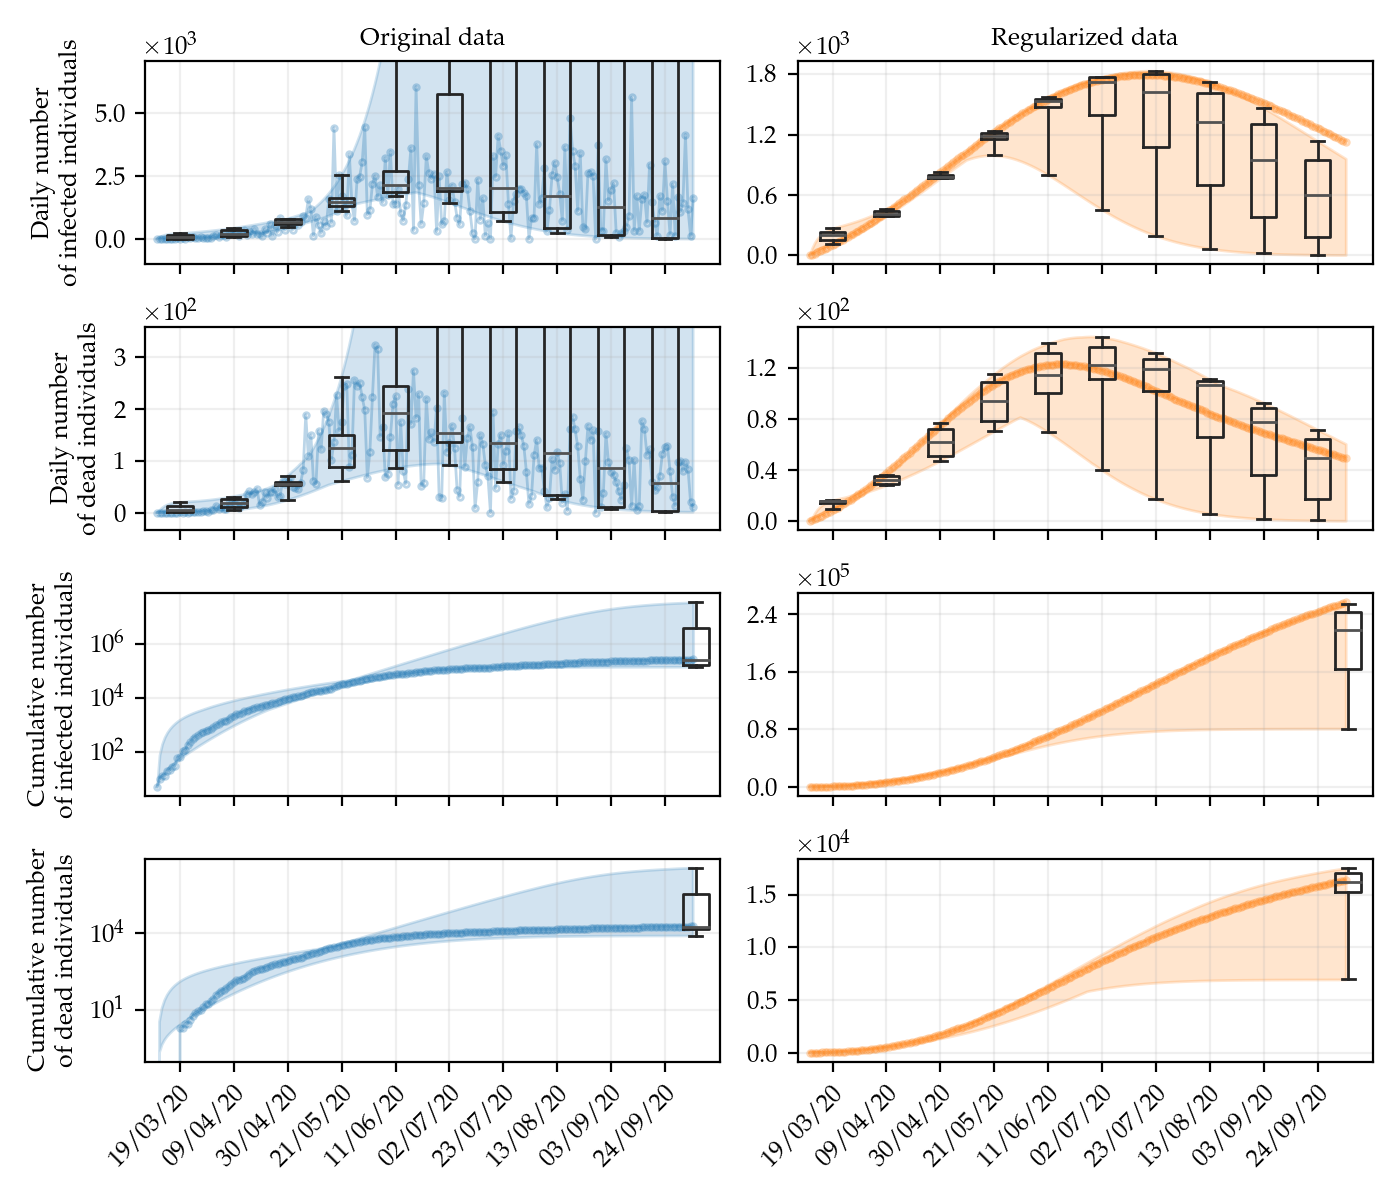

Interquartile range: [172065.92307684314, 3970094.37729328]
Median: 259406.49197324074
Interquartile range: [163064.34545870952, 243274.80777730112]
Median: 217621.46595893847
Interquartile range: [14796.499805720956, 342994.52341705596]
Median: 17313.497515055453
Interquartile range: [15249.382964361148, 17059.500670740756]
Median: 16196.682115292911


In [24]:
array_n_runs = np.linspace(1, n_runs, num=n_runs)

nrows = 4
ncols = 2
fig, ax = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(7, 6))

for i in range(nrows):
    for j in range(ncols):
        
        if j == 0:
            if i == 0:
                y_values = infected_individuals
                y_min = min_infected_original
                y_max = max_infected_original
            elif i == 1:
                y_values = dead_individuals
                y_min = min_dead_original
                y_max = max_dead_original
            elif i == 2:
                y_values = np.cumsum(infected_individuals)
                y_min = min_infected_original_cumsum
                y_max = max_infected_original_cumsum
            elif i == 3:
                y_values = np.cumsum(dead_individuals)
                y_min = min_dead_original_cumsum
                y_max = max_dead_original_cumsum    
            color_data = original_data_color
            color_sim = original_data_color
        elif j == 1:
            if i == 0:
                y_values = reg_data[0]
                y_min = min_infected_reg
                y_max = max_infected_reg
            elif i == 1:
                y_values = reg_data[1]
                y_min = min_dead_reg
                y_max = max_dead_reg
            elif i == 2:
                y_values = np.cumsum(reg_data[0])
                y_min = min_infected_reg_cumsum
                y_max = max_infected_reg_cumsum
            elif i == 3:
                y_values = np.cumsum(reg_data[1])
                y_min = min_dead_reg_cumsum
                y_max = max_dead_reg_cumsum
            color_data = reg_data_color
            color_sim = reg_data_color
        
        (ax[i, j]).plot(
            data_dates,
            y_values,
            marker="o",
            linestyle="-",
            markersize=2,
            linewidth=1,
            color=color_data,
            fillstyle="none",
            markeredgecolor=color_data,
            alpha=0.3
        )
        
        (ax[i, j]).fill_between(
            data_dates,
            y_min,
            y_max,
            color=color_sim,
            alpha=0.2
        )
        
        if i >= 2:
            if j == 0:
                (ax[i, j]).set_yscale('log')

            else:
                (ax[i, j]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
                (ax[i, j]).yaxis.set_major_locator(plt.MaxNLocator(4))
        else:
            (ax[i, j]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
            (ax[i, j]).yaxis.set_major_locator(plt.MaxNLocator(4))

        (ax[i, j]).grid(alpha=0.2)

        (ax[i, j]).xaxis.set_major_locator(mdates.DayLocator(interval=21))
        plt.setp((ax[i, j]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        (ax[i, j]).yaxis.major.formatter._useMathText = True

ticks_dates_pos = np.array((ax[3, 1]).get_xticks(), dtype=np.int)
ticks_dates = ["" for i in range(len(ticks_dates_pos)-1)]
for i in range(len(ticks_dates_pos)-1):
    ticks_dates[i] = data_dates[ticks_dates_pos[i]]
    
for i in range(nrows):
    for j in range(ncols):
        
        if i < 2:
            if i == 0:
                if j == 0:
                    y_values = infected_original
                elif j == 1:
                    y_values = infected_reg
            elif i == 1:
                if j == 0:
                    y_values = dead_original
                elif j == 1:
                    y_values = dead_reg
    
            bp_handler = (ax[i, j]).boxplot(y_values[:,ticks_dates_pos[:-1]],
                                            showfliers=False,
                                            whis=(0,100),
                                            positions=ticks_dates_pos[:-1],
                                            widths=10)
        else:
            if i == 2:
                if j == 0:
                    y_values = infected_original_cumsum
                elif j == 1:
                    y_values = infected_reg_cumsum
            elif i == 3:
                if j == 0:
                    y_values = dead_original_cumsum
                elif j == 1:
                    y_values = dead_reg_cumsum
                
            bp_handler = (ax[i, j]).boxplot(y_values[:,data_time.size-1],
                                            showfliers=False,
                                            whis=(0,100),
                                            positions=[data_time.size],
                                            widths=10)
            
            print(f"Interquartile range: [{np.percentile(y_values[:, -1], 25)}, {np.percentile(y_values[:, -1], 75)}]")
            print(f"Median: {np.median(y_values[:, -1])}")
        
        plt.setp(bp_handler["medians"], color="#525252")
        plt.setp(bp_handler["boxes"], color="#252525")
        plt.setp(bp_handler["whiskers"], color="#252525")
        plt.setp(bp_handler["caps"], color="#252525")
        
        xlim = (ax[i, j]).get_xlim()
        (ax[i, j]).set_xlim(xlim[0] - 0.1 * xlim[0], xlim[1] + 1e-4 * xlim[1])

plt.xticks(ticks_dates_pos[:-1], ticks_dates)

(ax[0, 0]).set_ylabel("Daily number\nof infected individuals")
(ax[1, 0]).set_ylabel("Daily number\nof dead individuals")

(ax[2, 0]).set_ylabel("Cumulative number\nof infected individuals")
(ax[3, 0]).set_ylabel("Cumulative number\nof dead individuals")

(ax[0, 0]).set_title("Original data", fontsize=fontsize)
(ax[0, 1]).set_title("Regularized data", fontsize=fontsize)

(ax[0, 0]).set_ylim(infected_original_limits)
(ax[1, 0]).set_ylim(dead_original_limits)

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "simulations" + ".pdf")

### Function to calculate root-mean-square error (RMSE)

In [25]:
def calc_rmse(data1, data2, num_days_prediction):
    diff_infected = data1[0, :] - data2[0, :]
    diff_dead = data1[1, :] - data2[1, :]
    
    infected_residual = (np.sqrt(np.power(np.sum(diff_infected), 2) / num_days_prediction)) / (np.max(data2[0, :]) - np.min(data2[0, :]))
    dead_residual = (np.sqrt(np.power(np.sum(diff_dead), 2) / num_days_prediction)) / (np.max(data2[1, :]) - np.min(data2[1, :]))
    
    rmse = dead_residual + infected_residual
    return rmse

### Calculating RMSE

RMSE reduction on average: 21.559 %
Runs with lower RMSE: 64.706 %
Original data: A = 899.66 u. a.
Regularized data: A = 705.70 u. a.
Number of training data where there was the greatest difference in RMSE: 131


<IPython.core.display.Javascript object>


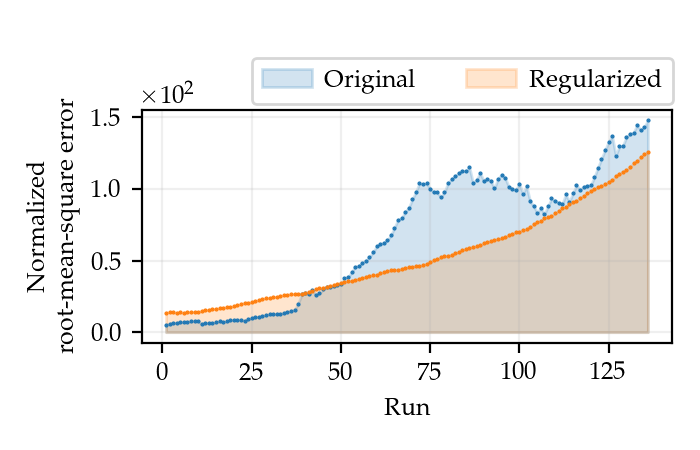

In [26]:
rmse_values_original = np.zeros(n_runs)
rmse_values_reg = np.zeros(n_runs)

for p, num_data_calibration in enumerate(np.arange(min_calibration_data, max_calibration_data, step_calibration_data)):
    for data_type in data_types:
        test_data = np.cumsum(original_data[:, num_data_calibration :
                                                      (num_data_calibration + num_days_prediction)], axis=1)
        if data_type == "original":
            test_simulation = np.zeros_like(test_data)
            test_simulation[0] = (infected_original_cumsum[p])[num_data_calibration :
                                                                (num_data_calibration + num_days_prediction)]
            test_simulation[1] = (dead_original_cumsum[p])[num_data_calibration :
                                                            (num_data_calibration + num_days_prediction)]
            rmse_values_original[p] = calc_rmse(test_data, test_simulation, num_days_prediction)
        elif data_type == "reg":
            test_simulation = np.zeros_like(test_data)
            test_simulation[0] = (infected_reg_cumsum[p])[num_data_calibration :
                                                                (num_data_calibration + num_days_prediction)]
            test_simulation[1] = (dead_reg_cumsum[p])[num_data_calibration :
                                                            (num_data_calibration + num_days_prediction)]
            
            rmse_values_reg[p] = calc_rmse(test_data, test_simulation, num_days_prediction)
            
area_rmse_original = simps(rmse_values_original, dx=1e-1)
area_rmse_reg = simps(rmse_values_reg, dx=1e-1)

print("RMSE reduction on average: %.3f %%" %((1 - (area_rmse_reg / area_rmse_original)) * 100))
print("Runs with lower RMSE: %.3f %%" %((float(np.size(np.where(rmse_values_reg < rmse_values_original))) /
                                         float(n_runs)) * 100))
print("Original data: A = %.2f u. a.\nRegularized data: A = %.2f u. a." %(area_rmse_original, area_rmse_reg))

idx_max_diff_rmse = int((np.where(np.abs(rmse_values_original -
                                rmse_values_reg) == np.max(np.abs(rmse_values_original -
                                                                  rmse_values_reg))))[0])

print("Number of training data where there was the greatest difference in RMSE: %d" %(min_calibration_data + idx_max_diff_rmse))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.25))

ax.fill_between(
    array_n_runs,
    rmse_values_original,
    linestyle="-",
    linewidth=1,
    color=original_data_color,
    alpha=0.2,
    label="Original",
)

ax.plot(
    array_n_runs,
    rmse_values_original,
    linestyle="",
    linewidth=0,
    marker="o",
    markersize=0.5,
    alpha=1
)

ax.fill_between(
    array_n_runs,
    rmse_values_reg,
    linestyle="-",
    linewidth=1,
    color=reg_data_color,
    alpha=0.2,
    label="Regularized",
)

ax.plot(
    array_n_runs,
    rmse_values_reg,
    linestyle="",
    linewidth=0,
    marker="o",
    markersize=0.5,
    alpha=1
)

ax.grid(alpha=0.2)

ax.set_xlabel("Run")
ax.set_ylabel("Normalized\nroot-mean-square error")

ax.ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ax.legend(loc="upper right", fontsize=fontsize, ncol=2, handletextpad=0.5, bbox_to_anchor=(1.025,1.275))

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "RMSE" + ".pdf")

### Functions for posterior calculation

In [27]:
def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calulating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

### ODE wrapper for bayesian calibration

In [28]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector,
        t.dvector,
        t.dscalar,
        t.dscalar,  # beta
        t.dscalar,  # omega
        t.dscalar,  # d_P
        t.dscalar,  # E0
    ],
    otypes=[t.dmatrix],
)
def seirpdq_ode_wrapper_with_y0(
    time_exp, initial_conditions, total_population, beta, omega, d_P, E0
):
    time_span = (time_exp.min(), time_exp.max())
    args = [beta, omega, d_P]

    S0 = total_population - (
        E0 + initial_conditions[0] + initial_conditions[1] + initial_conditions[2] + initial_conditions[3]
    )
    ICs = (
        S0,
        E0,
        initial_conditions[0],  # I
        initial_conditions[1],  # P
        initial_conditions[2],  # R
        initial_conditions[3],  # D
        initial_conditions[4],  # C
    )

    y_model = seirpdq_ode_solver(ICs, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    (_, _, _, simulated_qoi1, _, simulated_qoi2, _,) = simulated_ode_solution
    
    simulated_qoi2 = np.diff(simulated_qoi2)
    simulated_qoi2 = np.insert(simulated_qoi2, 0, simulated_qoi2[0])

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

### Days to simulate

In [29]:
num_days_to_simulate_bayes = max_calibration_data
data_time_to_simulate_bayes = data_time[:num_days_to_simulate_bayes]
dates_to_simulate_bayes = data_dates[:num_days_to_simulate_bayes]

### Bayesian calibration

In [30]:
if run_opt_bayes == True:
    for data_type in data_types:
        if data_type == "original":
            observations_to_fit = np.vstack([original_data[0,:num_days_to_simulate_bayes],
                                             original_data[1,:num_days_to_simulate_bayes]]).T
            I0, P0, R0, D0, C0 = (original_data[0, 0],
                                  original_data[0, 0],
                                  0,
                                  original_data[1, 0],
                                  original_data[0, 0])
        elif data_type == "reg":
            observations_to_fit = np.vstack([reg_data[0,:num_days_to_simulate_bayes],
                                             reg_data[1,:num_days_to_simulate_bayes]]).T
            I0, P0, R0, D0, C0 = (reg_data[0, 0],
                                  reg_data[0, 0],
                                  0,
                                  reg_data[1, 0],
                                  reg_data[0, 0])

        y0_seirpdq = np.array([I0, P0, R0, D0, C0], dtype=np.float64)
        
        with pm.Model() as model_mcmc:

            beta = pm.Uniform(calibration_variable_names[0], bounds_seirpdq[0][0], bounds_seirpdq[0][1])
            omega = pm.Uniform(calibration_variable_names[1], bounds_seirpdq[1][0], bounds_seirpdq[1][1])
            d_P = pm.Uniform(calibration_variable_names[2], bounds_seirpdq[2][0], bounds_seirpdq[2][1])
            E0 = pm.Uniform(calibration_variable_names[3], bounds_seirpdq[3][0], bounds_seirpdq[3][1])

            standard_deviation = pm.Uniform(
                calibration_variable_names[4],
                lower=1e0,
                upper=1e4,
                shape=2
            )

            fitting_model = pm.Deterministic(
                "seirpdq_model",
                seirpdq_ode_wrapper_with_y0(
                    theano.shared(data_time_to_simulate_bayes),
                    theano.shared(y0_seirpdq),
                    theano.shared(target_population),
                    beta,
                    omega,
                    d_P,
                    E0,
                ),
            )

            likelihood_model = pm.Normal(
                "likelihood_model",
                mu=fitting_model,
                sigma=standard_deviation,
                observed=observations_to_fit
            )

            seirpdq_trace_calibration = pm.sample_smc(
                draws=draws,
                n_steps=25,
                parallel=True,
                cores=8,
                progressbar=True,
                random_seed=seed
            )

        # Calibration realizations

        dict_realizations = dict()
        progress_bar = tqdm(calibration_variable_names[:-1])
        for variable in progress_bar:
            progress_bar.set_description(f"Gathering {variable} realizations")
            parameter_realization = seirpdq_trace_calibration.get_values(f"{variable}")
            dict_realizations[f"{variable}"] = parameter_realization

        df_realizations = pd.DataFrame(dict_realizations)
        df_realizations.to_csv(f"{OUTPUT_PATH}/calibration_realizations_{data_type}.csv")

### Read existing parameter realizations

In [31]:
for data_type in data_types:
    if data_type == "original":
        dict_realizations_original = pd.read_csv(f"{OUTPUT_PATH}/calibration_realizations_{data_type}.csv",
                                                 usecols=calibration_variable_names[:-1])
        trace_calibration = dict_realizations_original
    elif data_type == "reg":
        dict_realizations_reg = pd.read_csv(f"{OUTPUT_PATH}/calibration_realizations_{data_type}.csv",
                                            usecols=calibration_variable_names[:-1])
        trace_calibration = dict_realizations_reg

    # Summary of calibration

    df_stats_summary = az.summary(
        data=az.convert_to_inference_data(trace_calibration.to_dict(orient="list")),
        var_names=calibration_variable_names[:-1],
        kind='stats',
        round_to=24,
        hdi_prob=0.95,
    )
#     calibration_variable_modes = calculate_rv_posterior_mpv(
#         pm_trace=trace_calibration,
#         variable_names=calibration_variable_names
#     )
#     df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_modes)
    df_stats_summary.to_csv(f"{OUTPUT_PATH}/stats_summary_calibration_{data_type}.csv")

### Creating layout for posterior plotting

In [32]:
inner1 = [
    ["original1", "original2"],
    ["original3", "original4"],
]

inner2 = [
    ["reg1", "reg2"],
    ["reg3", "reg4"],
]

inner3 = [
    ["right1"],
    ["right2"],
]

inner4 = [
    ["right3"],
    ["right4"],
]

outer_nested_layout = [
    [inner1, inner3],
    [inner2, inner4],
]

### Posterior plotting

<IPython.core.display.Javascript object>


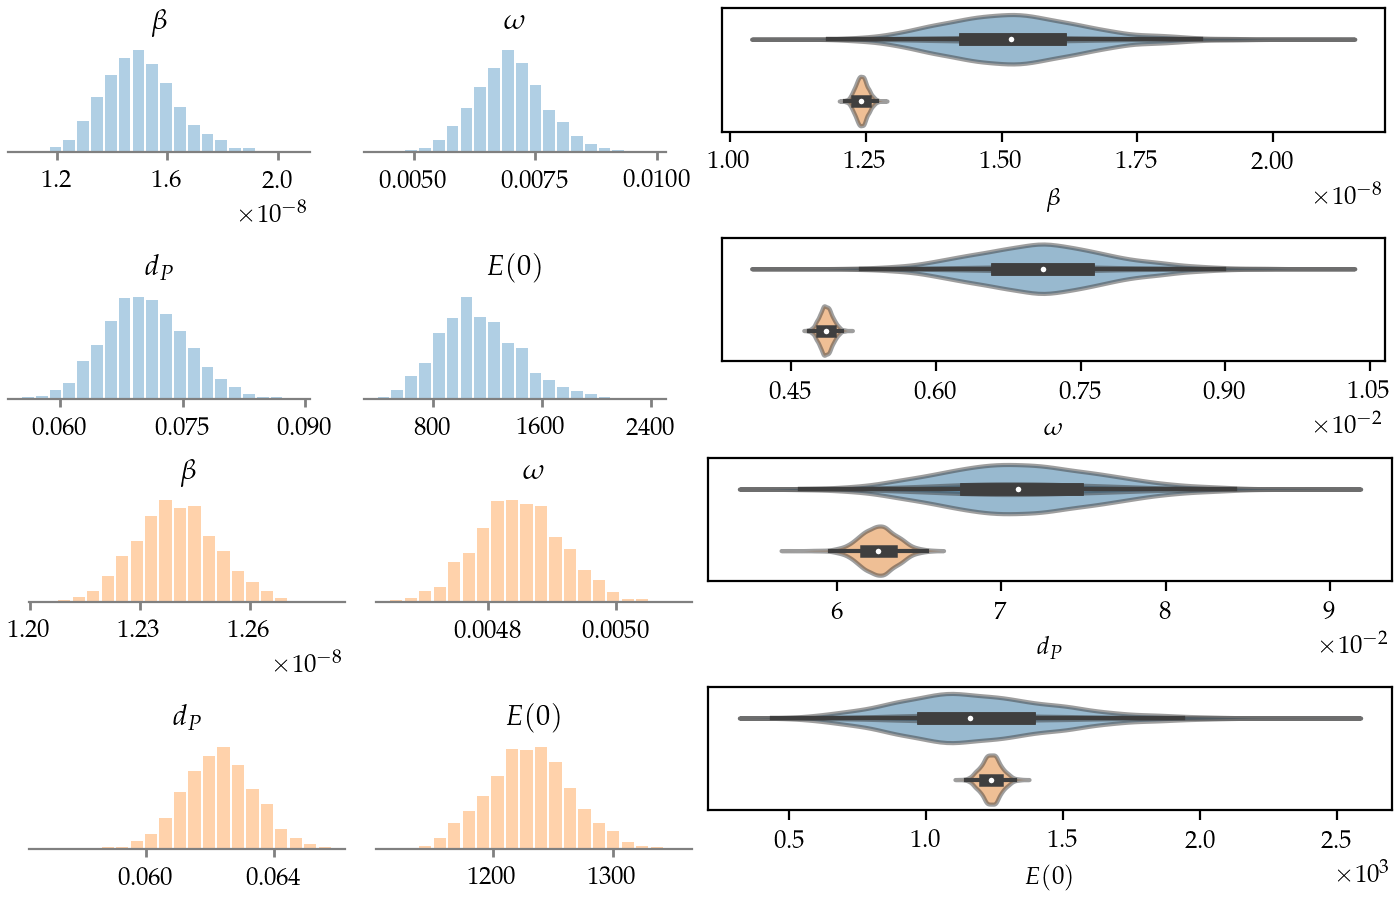

In [33]:
axd = plt.figure(figsize=(7, 4.5), constrained_layout=True).subplot_mosaic(
    outer_nested_layout
)

# pos_letter = (0, 1.15)
my_palette = {"original": original_data_color, "reg": reg_data_color}

for i, par_name in zip(range(len(calibration_variable_names)-1), calibration_variable_names[:-1]):
    
    parameters_realizations = pd.DataFrame(columns=["type", "value"])
    
    for data_type in data_types:

        loc_left=data_type+str(i+1)
        loc_right="right"+str(i+1)
        
        if data_type == "original":
            dict_realizations = dict_realizations_original
            color=original_data_color
        elif data_type == "reg":
            dict_realizations = dict_realizations_reg
            color=reg_data_color
        trace_calibration = az.convert_to_inference_data(dict_realizations.to_dict(orient="list"))
            
        par_realizations = pd.DataFrame({"type": np.repeat(np.array(data_type, dtype=np.str), draws),
                                         "value": dict_realizations[par_name]})
        parameters_realizations = parameters_realizations.append(par_realizations, ignore_index = True)
        
        ax_post = az.plot_posterior(
            trace_calibration, 
            var_names=calibration_variable_names[i], 
            kind="hist", 
            round_to=3,
            hdi_prob="hide",
            bins=20,
            point_estimate=None,
            textsize=fontsize,
            ax=axd[loc_left],
            facecolor=color,
            rwidth=0.85,
        )
        
        ax_violin = sns.violinplot(x="value",
                       y="type",
                       data=parameters_realizations,
                       dodge=True,
                       alpha=.05,
                       palette=my_palette,
                       ax=axd[loc_right]
        )
        
        for violin in ax_violin.collections[::2]:
            violin.set_alpha(0.5)
        
        axd[loc_right].set_xlabel(par_name)
        axd[loc_right].set_ylabel(None)
        axd[loc_right].tick_params(
            axis="y",
            which="both",
            left=False,
            labelleft=False
        )
        axd[loc_right].ticklabel_format(axis='x', useOffset=True, scilimits=(0,0))
        axd[loc_right].xaxis.major.formatter._useMathText = True
        axd[loc_right].xaxis.set_major_locator(plt.MaxNLocator(5))
        
        axd[loc_left].xaxis.major.formatter._useMathText = True
        axd[loc_left].xaxis.set_major_locator(plt.MaxNLocator(3))

#         if i == 0:
#             if data_type == "original":
#                 ax_post.text(pos_letter[0], pos_letter[1], r"\bf A", transform=ax_post.transAxes, size=fontsize)
#             if data_type == "reg":
#                 ax_post.text(pos_letter[0], pos_letter[1], r"\bf B", transform=ax_post.transAxes, size=fontsize)

plt.savefig(f"{OUTPUT_PATH}/param_posterior.pdf")

### Function for plotting bayesian simulation

In [34]:
def plot_bayes_simulation(ax, dates, X_min, X_max, X_color, X_sim):
    ax.fill_between(
        dates,
        X_min,
        X_max,
        color=X_color,
        alpha=0.2
    )

    ax.plot(
        dates,
        X_sim,
        marker=None,
        linestyle="-",
        markersize=0,
        linewidth=2,
        color=X_color,
        fillstyle="none",
        alpha=1
    )
    
def plot_data_bayes_simulation(ax, dates, data, X_color, inset):
    if inset == True:
        markersize = 5
    else:
        markersize = 2

    ax.plot(
        dates,
        data,
        marker="o",
        linestyle="-",
        markersize=markersize,
        linewidth=1,
        color=X_color,
        fillstyle="none",
        markeredgecolor=X_color,
        alpha=0.5
    )

### Days to simulate

In [35]:
num_days_to_simulate_bayes_cumsum = num_days_to_simulate_bayes + num_days_prediction
data_time_to_simulate_bayes_cumsum = data_time[:num_days_to_simulate_bayes_cumsum]
dates_to_simulate_bayes_cumsum = data_dates[:num_days_to_simulate_bayes_cumsum]

dates_to_simulate_bayes_train = dates_to_simulate_bayes_cumsum[:num_days_to_simulate_bayes]
dates_to_simulate_bayes_test = dates_to_simulate_bayes_cumsum[num_days_to_simulate_bayes:]

### Plotting bayesian calibration

<IPython.core.display.Javascript object>


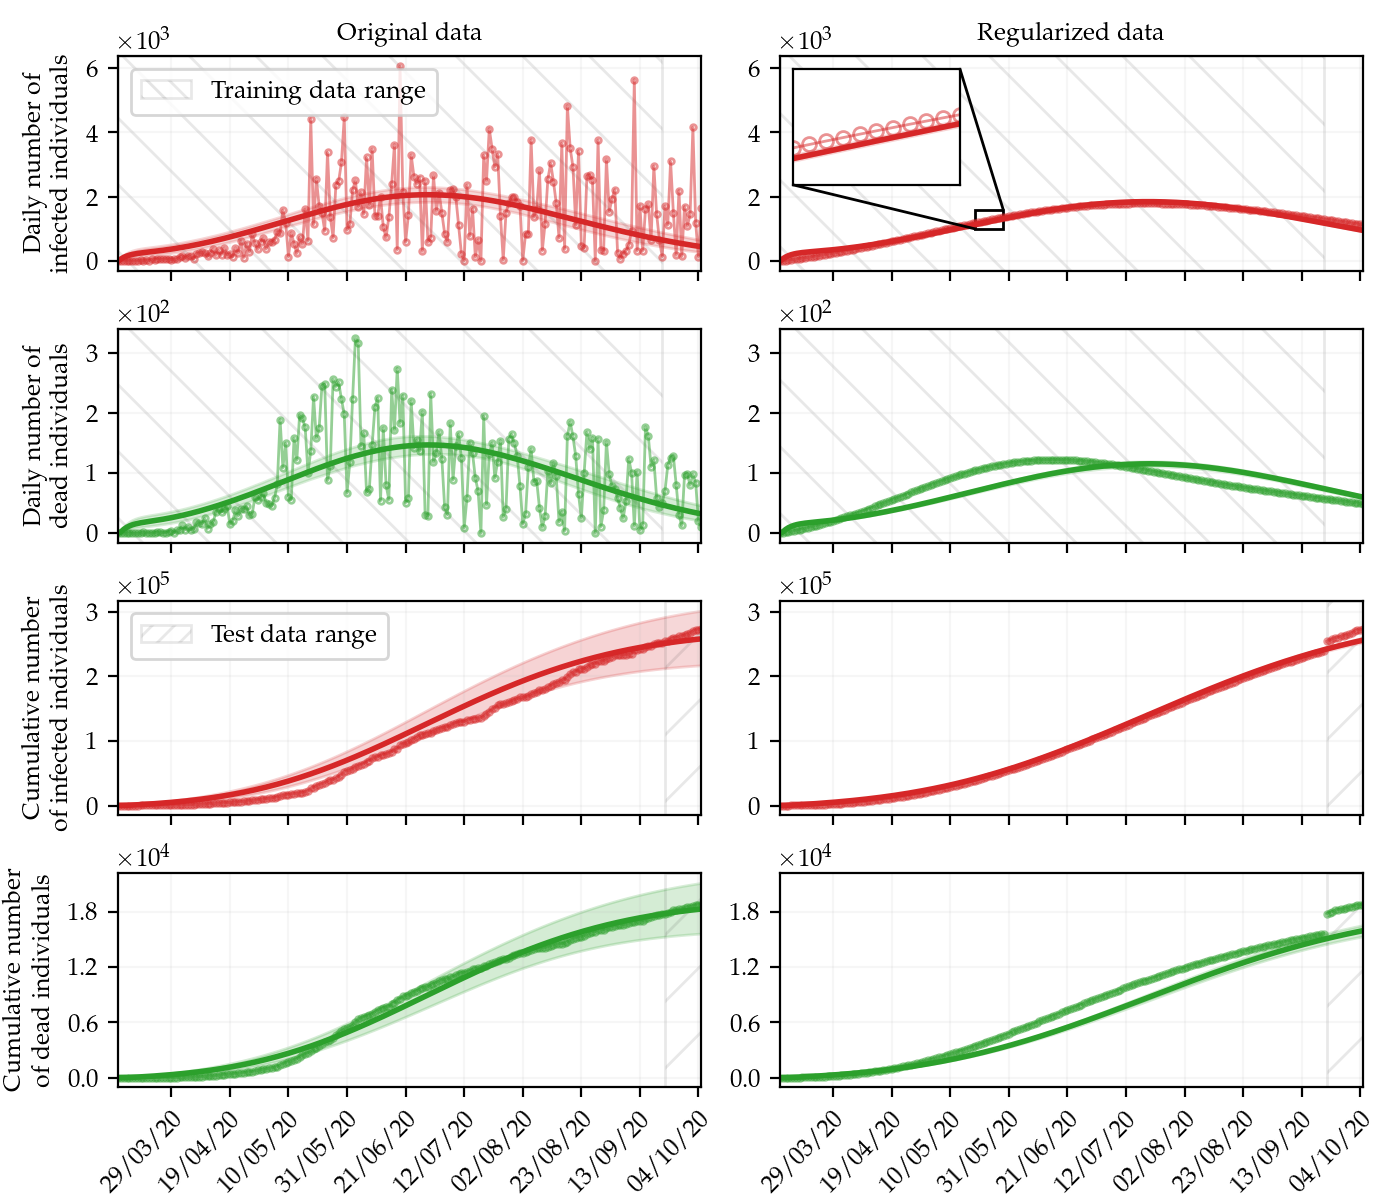

100%|██████████| 3000/3000 [00:20<00:00, 144.46it/s]
/Users/gustavolibotte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:252: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [36]:
nrows = 4
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(7, 6))

for j, data_type in enumerate(data_types):
    if data_type == "original":
        dict_realizations = dict_realizations_original
    elif data_type == "reg":
        dict_realizations = dict_realizations_reg

    S_simulation = list()
    E_simulation = list()
    I_simulation = list()
    P_simulation = list()
    R_simulation = list()
    D_simulation = list()
    C_simulation = list()

    number_of_total_realizations = len(dict_realizations[calibration_variable_names[0]])
    for realization in trange(number_of_total_realizations):

        parameters_realization = [
            dict_realizations[calibration_variable_names[0]][realization],
            dict_realizations[calibration_variable_names[1]][realization],
            dict_realizations[calibration_variable_names[2]][realization],
        ]

        E0 = dict_realizations[calibration_variable_names[3]][realization]
        y0_estimated = (
            target_population - (E0 + I0 + P0 + R0 + D0),
            E0,
            I0,
            P0,
            R0,
            D0,
            C0,
        )

        t0 = data_time_to_simulate_bayes_cumsum[0]
        tf = data_time_to_simulate_bayes_cumsum[-1]
        time_span_simulation = data_time_to_simulate_bayes_cumsum

        solution_ODE_simulation = seirpdq_ode_solver(
            y0_estimated, (t0, tf), time_span_simulation, *parameters_realization
        )

        t_computed_simulation, y_computed_simulation = solution_ODE_simulation.t, solution_ODE_simulation.y
        S, E, I, P, R, D, C = y_computed_simulation

        S_simulation.append(S)
        E_simulation.append(E)
        I_simulation.append(I)
        P_simulation.append(P)
        R_simulation.append(R)
        D_simulation.append(D)
        C_simulation.append(C)

    S_simulation = np.array(S_simulation)
    E_simulation = np.array(E_simulation)
    I_simulation = np.array(I_simulation)
    P_simulation = np.array(P_simulation)
    R_simulation = np.array(R_simulation)
    D_simulation = np.array(D_simulation)
    C_simulation = np.array(C_simulation)
    
    for i in range(number_of_total_realizations):
        D_simulation[i] = np.insert(np.diff(D_simulation[i]), 0, D_simulation[i, 0])
    
    S_min = np.percentile(S_simulation, percentile_cut, axis=0)
    S_max = np.percentile(S_simulation, 100 - percentile_cut, axis=0)
    S_mean = np.percentile(S_simulation, 50, axis=0)
    
    E_min = np.percentile(E_simulation, percentile_cut, axis=0)
    E_max = np.percentile(E_simulation, 100 - percentile_cut, axis=0)
    E_mean = np.percentile(E_simulation, 50, axis=0)

    I_min = np.percentile(I_simulation, percentile_cut, axis=0)
    I_max = np.percentile(I_simulation, 100 - percentile_cut, axis=0)
    I_mean = np.percentile(I_simulation, 50, axis=0)

    P_min = np.percentile(P_simulation, percentile_cut, axis=0)
    P_max = np.percentile(P_simulation, 100 - percentile_cut, axis=0)
    P_mean = np.percentile(P_simulation, 50, axis=0)

    R_min = np.percentile(R_simulation, percentile_cut, axis=0)
    R_max = np.percentile(R_simulation, 100 - percentile_cut, axis=0)
    R_mean = np.percentile(R_simulation, 50, axis=0)

    D_min = np.percentile(D_simulation, percentile_cut, axis=0)
    D_max = np.percentile(D_simulation, 100 - percentile_cut, axis=0)
    D_mean = np.percentile(D_simulation, 50, axis=0)

    C_min = np.percentile(C_simulation, percentile_cut, axis=0)
    C_max = np.percentile(C_simulation, 100 - percentile_cut, axis=0)
    C_mean = np.percentile(C_simulation, 50, axis=0)
        
    for i in range(nrows):
        if i == 0:
            X_min = P_min
            X_max = P_max
            X_sim = P_mean
            X_color = infected_color
        elif i == 1:
            X_min = D_min
            X_max = D_max
            X_sim = D_mean
            X_color = dead_color
        elif i == 2:
            X_min = np.cumsum(P_min)
            X_max = np.cumsum(P_max)
            X_sim = np.cumsum(P_mean)
            X_color = infected_color
        elif i == 3:
            X_min = np.cumsum(D_min)
            X_max = np.cumsum(D_max)
            X_sim = np.cumsum(D_mean)
            X_color = dead_color
        
        (ax[i, j]).grid(alpha=0.1)
        
        plot_bayes_simulation(ax[i, j], dates_to_simulate_bayes_cumsum, X_min, X_max, X_color, X_sim)

        if i < 2:
            if i == 0:
                if data_type == "original":
                    data_values = original_data[0,:num_days_to_simulate_bayes_cumsum]
                    X_color = infected_color
                elif data_type == "reg":
                    data_values = reg_data[0,:num_days_to_simulate_bayes_cumsum]
                    X_color = infected_color
            elif i == 1:
                if data_type == "original":
                    data_values = original_data[1,:num_days_to_simulate_bayes_cumsum]
                    X_color = dead_color
                elif data_type == "reg":
                    data_values = reg_data[1,:num_days_to_simulate_bayes_cumsum]
                    X_color = dead_color
            plot_data_bayes_simulation(ax[i, j], dates_to_simulate_bayes_cumsum, data_values, X_color, False)
        else:
            if data_type == "original":
                data_values_original = np.cumsum(original_data[:,:num_days_to_simulate_bayes_cumsum], axis=1)
                data_values_train = data_values_original[i-2,:num_days_to_simulate_bayes]
                data_values_test = data_values_original[i-2,num_days_to_simulate_bayes:num_days_to_simulate_bayes_cumsum]
                if i == 2:
                    X_color = infected_color
                elif i == 3:
                    X_color = dead_color
            elif data_type == "reg":
                data_values_reg = np.cumsum(reg_data[:,:num_days_to_simulate_bayes_cumsum], axis=1)
                data_values_train = data_values_reg[i-2,:num_days_to_simulate_bayes]
                data_values_test = data_values_original[i-2,num_days_to_simulate_bayes:num_days_to_simulate_bayes_cumsum]
                if i == 2:
                    X_color = infected_color
                elif i == 3:
                    X_color = dead_color
            plot_data_bayes_simulation(ax[i, j], dates_to_simulate_bayes_train, data_values_train, X_color, False)
            plot_data_bayes_simulation(ax[i, j], dates_to_simulate_bayes_test, data_values_test, X_color, False)

        (ax[i, j]).xaxis.set_major_locator(mdates.DayLocator(interval=21))
        plt.setp((ax[i, j]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        (ax[i, j]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
        (ax[i, j]).yaxis.major.formatter._useMathText = True
        (ax[i, j]).yaxis.set_major_locator(plt.MaxNLocator(4))
        
        if j == 1:
            if i == 0:
                axins = zoomed_inset_axes((ax[i, j]), 6, loc="upper left")
                plot_bayes_simulation(axins, dates_to_simulate_bayes_cumsum, X_min, X_max, X_color, X_sim)
                plot_data_bayes_simulation(axins, dates_to_simulate_bayes_cumsum, data_values, X_color, True)

                x1,x2,y1,y2 = 70,80,1e3,1.6e3
                axins.set_xlim(x1,x2)
                axins.set_ylim(y1,y2)
                
                mark_inset((ax[i, j]),axins,loc1=1,loc2=3)
                
                axins.tick_params(
                    axis="both",
                    which='both',
                    bottom=False,
                    top=False,
                    left=False,
                    right=False,
                    labelbottom=False,
                    labeltop=False,
                    labelleft=False,
                    labelright=False
                )    
            (ax[i, j]).set_ylim((ax[i, j-1]).get_ylim())
            (ax[i, j-1]).set_ylim((ax[i, j]).get_ylim())
        (ax[i, j]).set_xlim(dates_to_simulate_bayes_train[0], dates_to_simulate_bayes_test[-1])
                
for i in range(nrows):
    if i < 2:
        for j in range(ncols):
            (ax[i, j]).fill_between(
                dates_to_simulate_bayes_train,
                ((ax[i, j]).get_ylim())[0],
                ((ax[i, j]).get_ylim())[1],
                facecolor="#ffffff",
                edgecolor="#262626",
                alpha=0.1,
                hatch="\\",
            )
    else:
        for j in range(ncols):
            (ax[i, j]).fill_between(
                dates_to_simulate_bayes_test,
                ((ax[i, j]).get_ylim())[0],
                ((ax[i, j]).get_ylim())[1],
                color="#ffffff",
                edgecolor="#262626",
                alpha=0.1,
                hatch="/",
            )

(ax[0, 0]).set_ylabel("Daily number of\ninfected individuals")
(ax[1, 0]).set_ylabel("Daily number of\ndead individuals")

(ax[2, 0]).set_ylabel("Cumulative number\nof infected individuals")
(ax[3, 0]).set_ylabel("Cumulative number\nof dead individuals")

(ax[0, 0]).set_title("Original data", fontsize=fontsize)
(ax[0, 1]).set_title("Regularized data", fontsize=fontsize)

hatched_patch_right = mpatches.Patch(
    facecolor="#ffffff",
    edgecolor="#262626",
    alpha=0.1,
    label=label,
    hatch="///"
)

hatched_patch_left = mpatches.Patch(
    facecolor="#ffffff",
    edgecolor="#262626",
    alpha=0.1,
    label=label,
    hatch="\\\\\\"
)

(ax[0, 0]).legend(handles=[hatched_patch_left],
                  labels=["Training data range"],
                  loc="upper left",
                  fontsize=fontsize)
(ax[2, 0]).legend(handles=[hatched_patch_right],
                  labels=["Test data range"],
                  loc="upper left",
                  fontsize=fontsize)

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/bayes_simulation.pdf")

### Defining the model with time-varying $d_P$

In [37]:
@jit(nopython=True)
def seirpdq_model_vary_d_P(
    t,
    X,
    beta,
    gamma_I,
    gamma_P,
    d_0,
    d_1,
    omega,
    rho,
    sigma,
    N=1,
):
    """
    SEIRPD-Q python implementation.
    """
    d_P = d_0 * np.exp(-d_1 * t)
    
    S, E, I, P, R, D, C = X
    S_prime = -beta / N * S * I - omega * S
    E_prime = beta / N * S * I - sigma * E - omega * E
    I_prime = sigma * rho * E - gamma_I * I - omega * I
    P_prime = sigma * (1 - rho) * E - d_P * P - gamma_P * P
    R_prime = gamma_I * I + gamma_P * P + omega * (S + E + I)
    D_prime = d_P * P
    C_prime = sigma * (1 - rho) * E
    return S_prime, E_prime, I_prime, P_prime, R_prime, D_prime, C_prime

### Defining the ODE solver with time-varying $d_{P}$

In [38]:
def seirpdq_ode_solver_vary_d_P(
    y0,
    t_span,
    t_eval,
    beta,
    omega,
    d_0,
    d_1,
    gamma_P=1 / 16.7,
    gamma_I=1 / 16.7,
    rho=0.6,
    sigma=1 / 5.8,
    N=1,
):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seirpdq_model_vary_d_P(
            t,
            y,
            beta=beta,
            gamma_I=gamma_I,
            gamma_P=gamma_P,
            d_0=d_0,
            d_1=d_1,
            omega=omega,
            rho=rho,
            sigma=sigma,
            N=N,
        ),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        method="LSODA",
    )

    return solution_ODE

### Function for model simulation with time-varying $d_P$

In [39]:
def simulate_model_vary_d_P(data_time, y0, pars):
    S0 = target_population - (pars[4] + y0[0] + y0[1] + y0[2] + y0[3])
    y0_sol = S0, pars[4], y0[0], y0[1], y0[2], y0[3], y0[4]

    t0 = float(data_time.min())
    tf = float(data_time.max())

    solution_ODE = seirpdq_ode_solver_vary_d_P(
        y0_sol, (t0, tf), data_time, pars[0], pars[1], pars[2], pars[3]
    )

    t_solution_ODE, y_solution_ODE = (
        solution_ODE.t,
        solution_ODE.y,
    )
    
    return y_solution_ODE

### Defining optimization algorithm search space with time-varying $d_{P}$

In [40]:
bounds_seirpdq = [
    (0, 1e-6),   # beta
    (0, 1.0),    # omega
    (0, 1.0),    # d_0
    (0, 1.0),    # d_1
    (0, 10000),  # E0
]

### Solving the problem $ n_{\text{runs}} $ times with time-varying $d_{P}$

In [41]:
if run_opt_var == True:
    for data_type in data_types:
    
        beta_values = np.zeros(n_runs)
        omega_values = np.zeros(n_runs)
        d_0_values = np.zeros(n_runs)
        d_1_values = np.zeros(n_runs)
        E0_values = np.zeros(n_runs)
        
        bounds = np.zeros_like(bounds_seirpdq, dtype=np.float64)
        x0 = np.array([2.5e-8, 1.7e-2, 1e-1, 5e-3, 5e2])
        
        if data_type == "original":
            I0, P0, R0, D0, C0 = (original_data[0, 0], original_data[0, 0], 0, original_data[1, 0], original_data[0, 0])
        elif data_type == "reg":
            I0, P0, R0, D0, C0 = (reg_data[0, 0], reg_data[0, 0], 0, reg_data[1, 0], reg_data[0, 0])

        y0_seirpdq = np.array([I0, P0, R0, D0, C0], dtype=np.float64)

        for p, num_data_calibration in enumerate(np.arange(min_calibration_data, max_calibration_data, step_calibration_data)):
            data_time_validation = data_time[num_data_calibration : (num_data_calibration + num_days_prediction)]
            validation_data = original_data[:, num_data_calibration : (num_data_calibration + num_days_prediction)]

            data_time_calibration = data_time[0 : num_data_calibration]
            if data_type == "original":
                calibration_data = original_data[:, 0 : num_data_calibration] # Using original data
            elif data_type == "reg":
                calibration_data = reg_data[:, 0 : num_data_calibration] # Using regularized dataset

            print("\nRun: %d/%d\n" %(p+1, n_runs))

            success_res = False
            while success_res == False:

                print(x0)

                result_NM = optimize.minimize(
                    seirpdq_least_squares_error_ode_y0,
                    x0=x0,
                    args=(
                        data_time_calibration,
                        calibration_data,
                        seirpdq_ode_solver_vary_d_P,
                        y0_seirpdq,
                        target_population,
                    ),
                    method="Nelder-Mead",
                    options={"maxiter": 500},
                )
                                
                if result_NM.success == True and np.all(result_NM.x > 0):
                    sol_NM = result_NM.x
                    for k in range(len(x0)):
                        bounds[k] = (sol_NM[k] - 0.05 * sol_NM[k], sol_NM[k] + 0.05 * sol_NM[k])

                    result_DE = optimize.differential_evolution(
                        seirpdq_least_squares_error_ode_y0,
                        bounds=bounds,
                        args=(
                            data_time_calibration,
                            calibration_data,
                            seirpdq_ode_solver_vary_d_P,
                            y0_seirpdq,
                            target_population,
                        ),
                        popsize=20,
                        strategy="best1bin",
                        tol=1e-6,
                        recombination=0.95,
                        mutation=0.6,
                        maxiter=1000,
                        polish=True,
                        init="latinhypercube",
                        disp=False,
                        seed=seed,
                        callback=None,
                        updating="deferred",
                        workers=-1,
                    )
                    success_res = result_DE.success

                else:
                    for i in range(len(bounds_seirpdq)):
                        sign = np.random.uniform(0, 0.01, 1)
                        shift = sign * x0[i]

                        if np.random.uniform(0, 1, 1) < 0.5:
                            x0[i] = x0[i] - shift
                        else:
                            x0[i] = x0[i] + shift

            print(result_DE)

            opt_pars = result_DE.x
            (
                beta_deterministic,
                omega_deterministic,
                d_0_deterministic,
                d_1_deterministic,
                E0_deterministic
            ) = opt_pars

            beta_values[p] = beta_deterministic
            omega_values[p] = omega_deterministic
            d_0_values[p] = d_0_deterministic
            d_1_values[p] = d_1_deterministic
            E0_values[p] = E0_deterministic

            y_solution_ODE = simulate_model(data_time, y0_seirpdq, opt_pars)

            (
                S_predict_seirpdq,
                E_predict_seirpdq,
                I_predict_seirpdq,
                P_predict_seirpdq,
                R_predict_seirpdq,
                D_predict_seirpdq,
                C_predict_seirpdq,
            ) = y_solution_ODE

            x0 = opt_pars
            for i in range(len(bounds_seirpdq)):
                sign = np.random.uniform(0, 0.01, 1)
                shift = sign * x0[i]

                if np.random.uniform(0, 1, 1) < 0.5:
                    x0[i] = x0[i] - shift
                else:
                    x0[i] = x0[i] + shift

        pd.DataFrame(beta_values).to_csv(f"{OUTPUT_PATH}/beta_{data_type}_var.csv")
        pd.DataFrame(omega_values).to_csv(f"{OUTPUT_PATH}/omega_{data_type}_var.csv")
        pd.DataFrame(d_0_values).to_csv(f"{OUTPUT_PATH}/d_0_{data_type}_var.csv")
        pd.DataFrame(d_1_values).to_csv(f"{OUTPUT_PATH}/d_1_{data_type}_var.csv")
        pd.DataFrame(E0_values).to_csv(f"{OUTPUT_PATH}/E0_{data_type}_var.csv")

### Loading new optimal parameters

In [42]:
for data_type in data_types:
    if data_type == "original":
        beta_values_original_var = pd.read_csv(f"{OUTPUT_PATH}/beta_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
        omega_values_original_var = pd.read_csv(f"{OUTPUT_PATH}/omega_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
        d_0_values_original_var = pd.read_csv(f"{OUTPUT_PATH}/d_0_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
        d_1_values_original_var = pd.read_csv(f"{OUTPUT_PATH}/d_1_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
        E0_values_original_var = pd.read_csv(f"{OUTPUT_PATH}/E0_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
    elif data_type == "reg":
        beta_values_reg_var = pd.read_csv(f"{OUTPUT_PATH}/beta_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
        omega_values_reg_var = pd.read_csv(f"{OUTPUT_PATH}/omega_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
        d_0_values_reg_var = pd.read_csv(f"{OUTPUT_PATH}/d_0_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
        d_1_values_reg_var = pd.read_csv(f"{OUTPUT_PATH}/d_1_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()
        E0_values_reg_var = pd.read_csv(f"{OUTPUT_PATH}/E0_{data_type}_var.csv", sep=',', usecols=[1]).to_numpy().ravel()

### Calculating $d_P \left( t \right)$ using optimal parameters

In [43]:
d_P_var_original = np.zeros((len(d_0_values_original_var), len(array_n_runs)))
d_P_var_reg = np.zeros_like(d_P_var_original)
for data_type in data_types:
    for k in range(len(d_0_values_original_var)):
        for t in range(len(array_n_runs)):
            if data_type == "original":
                d0 = d_0_values_original_var[k]
                d1 = d_1_values_original_var[k]
                d_P_var_original[k, t] = d0 * np.exp(-d1 * t)
            elif data_type == "reg":
                d0 = d_0_values_reg_var[k]
                d1 = d_1_values_reg_var[k]
                d_P_var_reg[k, t] = d0 * np.exp(-d1 * t)
                
d_P_var_original_min = np.percentile(d_P_var_original, 0, axis=0)
d_P_var_original_max = np.percentile(d_P_var_original, 100, axis=0)

d_P_var_reg_min = np.percentile(d_P_var_reg, 0, axis=0)
d_P_var_reg_max = np.percentile(d_P_var_reg, 100, axis=0)

### Creating layout for plotting optimal parameters

In [44]:
upper_frame = [
    ["beta", "omega", "E0"],
]

middle_frame = [
    ["d_0", "d_1"],
]

bottom_frame = [
    ["d_P_original", "d_P_reg"],
]

outer_nested_layout = [
    [upper_frame],
    [middle_frame],
    [bottom_frame],
]

### Plotting new optimal parameters

<IPython.core.display.Javascript object>


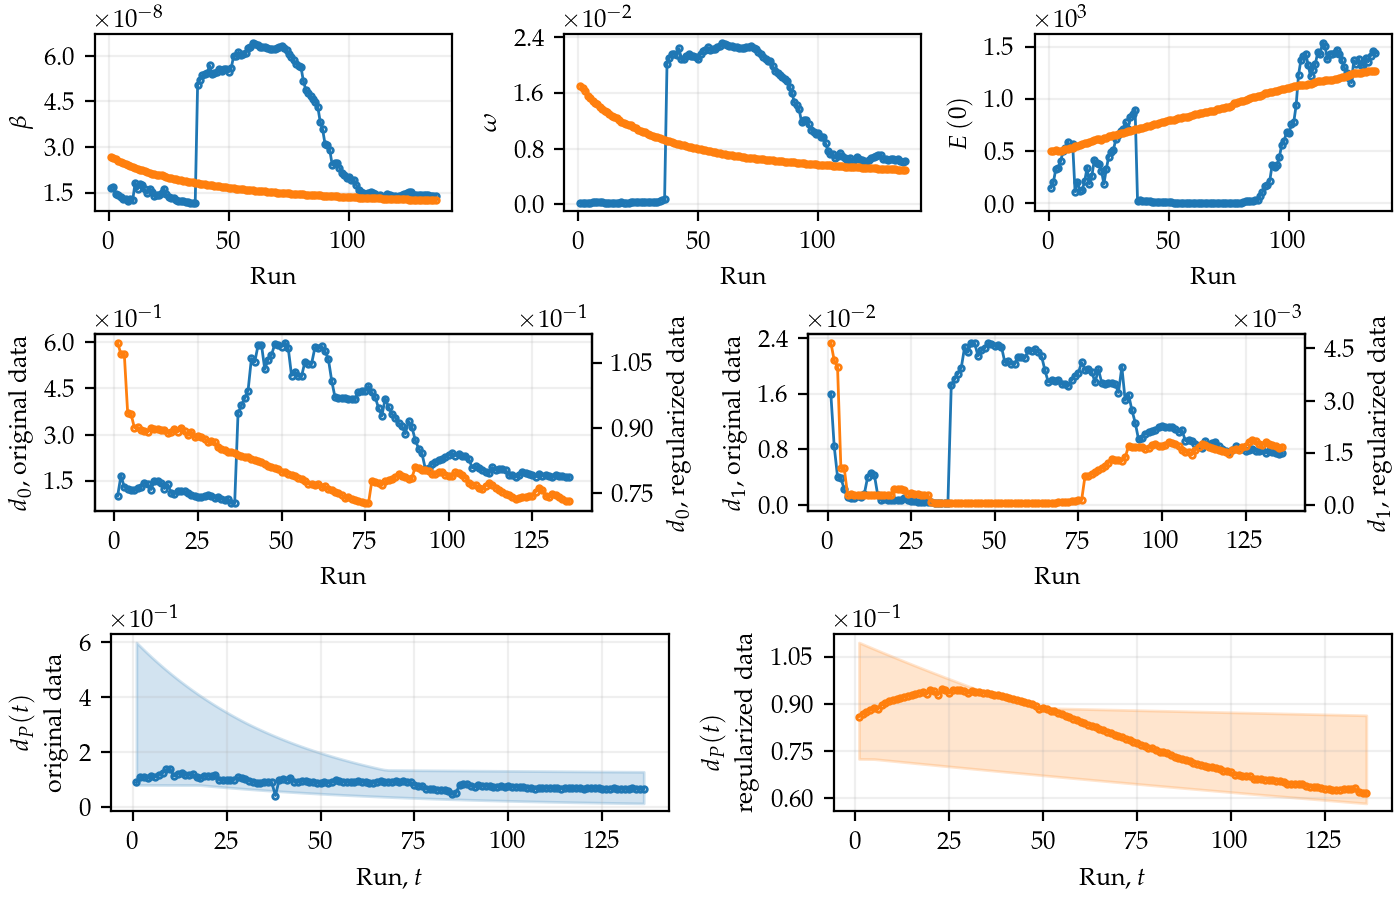

/Users/gustavolibotte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [45]:
array_n_runs = np.linspace(1, n_runs, num=n_runs)

axd = plt.figure(figsize=(7, 4.5), constrained_layout=True).subplot_mosaic(
    outer_nested_layout
)
####################

(axd["beta"]).grid(alpha=0.2)

(axd["beta"]).plot(
    array_n_runs,
    beta_values_original_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C0",
    fillstyle="none",
    markeredgecolor="C0",
    label="Original"
)

(axd["beta"]).plot(
    array_n_runs,
    beta_values_reg_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C1",
    fillstyle="none",
    markeredgecolor="C1",
    label="Regularized"
)

(axd["beta"]).set_xlabel("Run")
(axd["beta"]).set_ylabel(r"$\beta$")
# (axd["beta"]).legend(loc="upper right", fontsize=fontsize, ncol=2, handletextpad=0.5, bbox_to_anchor=(1.025,1.325))

(axd["beta"]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(axd["beta"]).yaxis.major.formatter._useMathText = True
(axd["beta"]).yaxis.set_major_locator(plt.MaxNLocator(4))

####################

(axd["omega"]).grid(alpha=0.2)

(axd["omega"]).plot(
    array_n_runs,
    omega_values_original_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C0",
    fillstyle="none",
    markeredgecolor="C0"
)

(axd["omega"]).plot(
    array_n_runs,
    omega_values_reg_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C1",
    fillstyle="none",
    markeredgecolor="C1"
)

(axd["omega"]).set_xlabel("Run")
(axd["omega"]).set_ylabel(r"$\omega$")

(axd["omega"]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(axd["omega"]).yaxis.major.formatter._useMathText = True
(axd["omega"]).yaxis.set_major_locator(plt.MaxNLocator(4))

####################

(axd["d_0"]).grid(alpha=0.2)

(axd["d_0"]).plot(
    array_n_runs,
    d_0_values_original_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C0",
    fillstyle="none",
    markeredgecolor="C0"
)

ax10 = (axd["d_0"]).twinx()

ax10.plot(
    array_n_runs,
    d_0_values_reg_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C1",
    fillstyle="none",
    markeredgecolor="C1"
)

(axd["d_0"]).set_xlabel("Run")
(axd["d_0"]).set_ylabel(r"$d_{0}$, original data")
ax10.set_ylabel(r"$d_{0}$, regularized data")

(axd["d_0"]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(axd["d_0"]).yaxis.major.formatter._useMathText = True
(axd["d_0"]).yaxis.set_major_locator(plt.MaxNLocator(4))

ax10.ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
ax10.yaxis.major.formatter._useMathText = True
ax10.yaxis.set_major_locator(plt.MaxNLocator(4))

####################

(axd["d_1"]).grid(alpha=0.2)

(axd["d_1"]).plot(
    array_n_runs,
    d_1_values_original_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C0",
    fillstyle="none",
    markeredgecolor="C0"
)

ax20 = (axd["d_1"]).twinx()

ax20.plot(
    array_n_runs,
    d_1_values_reg_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C1",
    fillstyle="none",
    markeredgecolor="C1"
)

(axd["d_1"]).set_xlabel("Run")
(axd["d_1"]).set_ylabel(r"$d_{1}$, original data")
ax20.set_ylabel(r"$d_{1}$, regularized data")

(axd["d_1"]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(axd["d_1"]).yaxis.major.formatter._useMathText = True
(axd["d_1"]).yaxis.set_major_locator(plt.MaxNLocator(4))

ax20.ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
ax20.yaxis.major.formatter._useMathText = True
ax20.yaxis.set_major_locator(plt.MaxNLocator(4))

####################

(axd["E0"]).grid(alpha=0.2)

(axd["E0"]).plot(
    array_n_runs,
    E0_values_original_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C0",
    fillstyle="none",
    markeredgecolor="C0"
)

(axd["E0"]).plot(
    array_n_runs,
    E0_values_reg_var,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C1",
    fillstyle="none",
    markeredgecolor="C1"
)

(axd["E0"]).set_xlabel("Run")
(axd["E0"]).set_ylabel(r"$E \left( 0 \right)$")

(axd["E0"]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(axd["E0"]).yaxis.major.formatter._useMathText = True
(axd["E0"]).yaxis.set_major_locator(plt.MaxNLocator(4))

####################

(axd["d_P_original"]).grid(alpha=0.2)

(axd["d_P_original"]).fill_between(
    array_n_runs,
    d_P_var_original_min,
    d_P_var_original_max,
    color="C0",
    alpha=0.2
)

(axd["d_P_original"]).plot(
    array_n_runs,
    d_P_values_original,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C0",
    fillstyle="none",
    markeredgecolor="C0"
)

(axd["d_P_original"]).set_xlabel(r"Run, $t$")
(axd["d_P_original"]).set_ylabel(r"$d_{P} (t)${\newline}original data")

(axd["d_P_original"]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(axd["d_P_original"]).yaxis.major.formatter._useMathText = True
(axd["d_P_original"]).yaxis.set_major_locator(plt.MaxNLocator(4))

####################

(axd["d_P_reg"]).grid(alpha=0.2)

(axd["d_P_reg"]).fill_between(
    array_n_runs,
    d_P_var_reg_min,
    d_P_var_reg_max,
    color="C1",
    alpha=0.2
)

(axd["d_P_reg"]).plot(
    array_n_runs,
    d_P_values_reg,
    marker="o",
    linestyle="-",
    markersize=2,
    linewidth=1,
    color="C1",
    fillstyle="none",
    markeredgecolor="C1"
)

(axd["d_P_reg"]).set_xlabel(r"Run, $t$")
(axd["d_P_reg"]).set_ylabel(r"$d_{P} (t)${\newline}regularized data")

(axd["d_P_reg"]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
(axd["d_P_reg"]).yaxis.major.formatter._useMathText = True
(axd["d_P_reg"]).yaxis.set_major_locator(plt.MaxNLocator(4))

# (axd["d_P_original"]).set_ylim(((axd["d_P_original"]).get_ylim())[0], 1.5e-1)

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "opt_params_var" + ".pdf")

### Calculating simulations using optimal parameters

In [46]:
infected_original_var = np.zeros((n_runs, data_time.size))
infected_original_var_cumsum = np.zeros((n_runs, data_time.size))
dead_original_var = np.zeros((n_runs, data_time.size))
dead_original_var_cumsum = np.zeros((n_runs, data_time.size))

infected_reg_var = np.zeros((n_runs, data_time.size))
infected_reg_var_cumsum = np.zeros((n_runs, data_time.size))
dead_reg_var = np.zeros((n_runs, data_time.size))
dead_reg_var_cumsum = np.zeros((n_runs, data_time.size))

for data_type in data_types:
    if data_type == "original":
        I0, P0, R0, D0, C0 = (original_data[0, 0],
                              original_data[0, 0],
                              0,
                              original_data[1, 0],
                              original_data[0, 0])
    elif data_type == "reg":
        I0, P0, R0, D0, C0 = (reg_data[0, 0],
                              reg_data[0, 0],
                              0,
                              reg_data[1, 0],
                              reg_data[0, 0])
        
    y0_seirpdq = np.array([I0, P0, R0, D0, C0], dtype=np.float64)
        
    for i in range(n_runs):
        if data_type == "original":
            opt_pars = np.array([beta_values_original_var[i],
                                 omega_values_original_var[i],
                                 d_0_values_original_var[i],
                                 d_1_values_original_var[i],
                                 E0_values_original_var[i]])
        elif data_type == "reg":
            opt_pars = np.array([beta_values_reg_var[i],
                                 omega_values_reg_var[i],
                                 d_0_values_reg_var[i],
                                 d_1_values_reg_var[i],
                                 E0_values_reg_var[i]])
    
        y_simulation = simulate_model_vary_d_P(data_time, y0_seirpdq, opt_pars)
        (
            S_simulation,
            E_simulation,
            I_simulation,
            P_simulation,
            R_simulation,
            D_simulation,
            C_simulation,
        ) = y_simulation
        
        if data_type == "original":
            infected_original_var[i, :] = P_simulation
            infected_original_var_cumsum[i, :] = np.cumsum(P_simulation)
            
            dead_original_var[i, 1:] = np.diff(D_simulation)
            dead_original_var[i, 0] = 0
            dead_original_var_cumsum[i, :] = D_simulation
        elif data_type == "reg":
            infected_reg_var[i, :] = P_simulation
            infected_reg_var_cumsum[i, :] = np.cumsum(P_simulation)
            
            dead_reg_var[i, 1:] = np.diff(D_simulation)
            dead_reg_var[i, 0] = 0
            dead_reg_var_cumsum[i, :] = D_simulation

#####################
# Bounds simulation #
#####################

# Daily
min_infected_original_var = np.percentile(infected_original_var, 0, axis=0)
max_infected_original_var = np.percentile(infected_original_var, 100, axis=0)

min_dead_original_var = np.percentile(dead_original_var, 0, axis=0)
max_dead_original_var = np.percentile(dead_original_var, 100, axis=0)

min_infected_reg_var = np.percentile(infected_reg_var, 0, axis=0)
max_infected_reg_var = np.percentile(infected_reg_var, 100, axis=0)

min_dead_reg_var = np.percentile(dead_reg_var, 0, axis=0)
max_dead_reg_var = np.percentile(dead_reg_var, 100, axis=0)

# Cumulative
min_infected_original_var_cumsum = np.percentile(infected_original_var_cumsum, 0, axis=0)
max_infected_original_var_cumsum = np.percentile(infected_original_var_cumsum, 100, axis=0)

min_dead_original_var_cumsum = np.percentile(dead_original_var_cumsum, 0, axis=0)
max_dead_original_var_cumsum = np.percentile(dead_original_var_cumsum, 100, axis=0)

min_infected_reg_var_cumsum = np.percentile(infected_reg_var_cumsum, 0, axis=0)
max_infected_reg_var_cumsum = np.percentile(infected_reg_var_cumsum, 100, axis=0)

min_dead_reg_var_cumsum = np.percentile(dead_reg_var_cumsum, 0, axis=0)
max_dead_reg_var_cumsum = np.percentile(dead_reg_var_cumsum, 100, axis=0)

### Plotting simulations with new parameters

#### Daily data

<IPython.core.display.Javascript object>


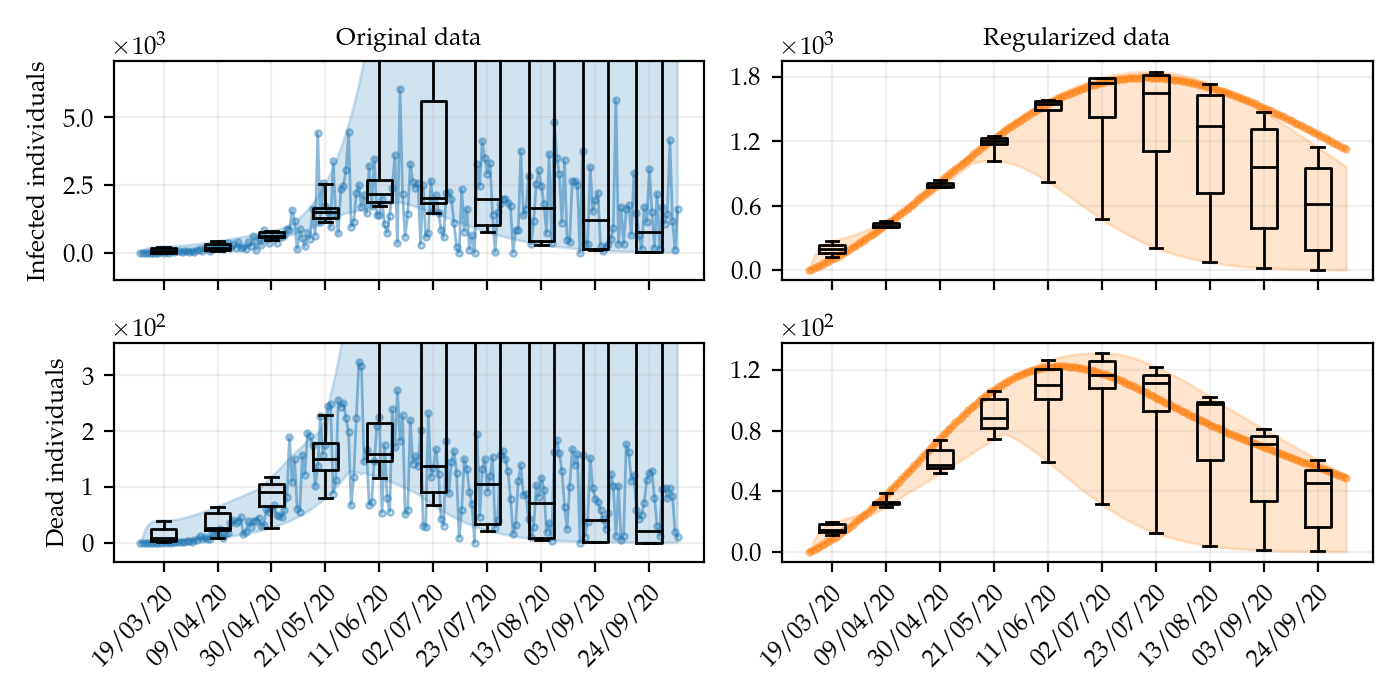

In [47]:
array_n_runs = np.linspace(1, n_runs, num=n_runs)

nrows = ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(7, 3.5))

for i in range(ncols):
    for j in range(nrows):
        
        if i == 0 and j == 0:
            y_values = infected_individuals
            y_min = min_infected_original_var
            y_max = max_infected_original_var
            color_data = original_data_color
            color_sim = original_data_color
        if i == 0 and j == 1:
            y_values = reg_data[0]
            y_min = min_infected_reg_var
            y_max = max_infected_reg_var
            color_data = reg_data_color
            color_sim = reg_data_color
        if i == 1 and j == 0:
            y_values = dead_individuals
            y_min = min_dead_original_var
            y_max = max_dead_original_var
            color_data = original_data_color
            color_sim = original_data_color
        if i == 1 and j == 1:
            y_values = reg_data[1]
            y_min = min_dead_reg_var
            y_max = max_dead_reg_var
            color_data = reg_data_color
            color_sim = reg_data_color
        
        (ax[i, j]).plot(
            data_dates,
            y_values,
            marker="o",
            linestyle="-",
            markersize=2,
            linewidth=1,
            color=color_data,
            fillstyle="none",
            markeredgecolor=color_data,
            alpha=0.5
        )
        
        (ax[i, j]).fill_between(
            data_dates,
            y_min,
            y_max,
            color=color_sim,
            alpha=0.2
        )

        (ax[i, j]).grid(alpha=0.2)

        (ax[i, j]).xaxis.set_major_locator(mdates.DayLocator(interval=21))
        plt.setp((ax[i, j]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        (ax[i, j]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
        (ax[i, j]).yaxis.major.formatter._useMathText = True
        (ax[i, j]).yaxis.set_major_locator(plt.MaxNLocator(4))

ticks_dates_pos = np.array((ax[1, 1]).get_xticks(), dtype=np.int)
ticks_dates = ["" for i in range(len(ticks_dates_pos)-1)]
for i in range(len(ticks_dates_pos)-1):
    ticks_dates[i] = data_dates[ticks_dates_pos[i]]
    
for i in range(ncols):
    for j in range(nrows):
        
        if i == 0 and j == 0:
            y_values = infected_original_var
        if i == 0 and j == 1:
            y_values = infected_reg_var
        if i == 1 and j == 0:
            y_values = dead_original_var
        if i == 1 and j == 1:
            y_values = dead_reg_var
    
        bp_handler = (ax[i, j]).boxplot(y_values[:,ticks_dates_pos[:-1]],
                                        showfliers=False,
                                        whis=(0,100),
                                        positions=ticks_dates_pos[:-1],
                                        widths=10)

        plt.setp(bp_handler["medians"], color="#000000")

plt.xticks(ticks_dates_pos[:-1], ticks_dates)

(ax[0, 0]).set_ylabel("Infected individuals")
(ax[1, 0]).set_ylabel("Dead individuals")

(ax[0, 0]).set_title("Original data", fontsize=fontsize)
(ax[0, 1]).set_title("Regularized data", fontsize=fontsize)

(ax[0, 0]).set_ylim(infected_original_limits)
(ax[1, 0]).set_ylim(dead_original_limits)

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "simulations_var" + ".pdf")

#### Cumulative data

<IPython.core.display.Javascript object>


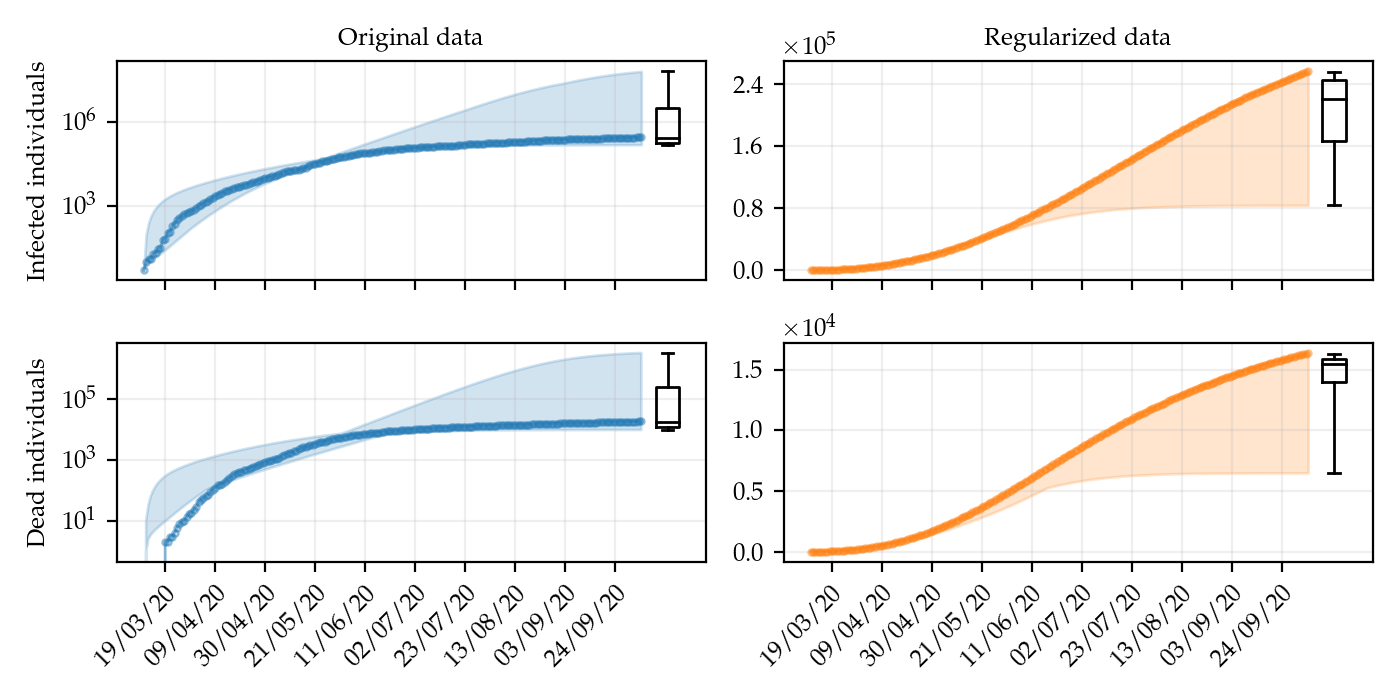

In [48]:
array_n_runs = np.linspace(1, n_runs, num=n_runs)

nrows = ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(7, 3.5))

for i in range(ncols):
    for j in range(nrows):
        
        if i == 0 and j == 0:
            y_values = np.cumsum(infected_individuals)
            y_min = min_infected_original_var_cumsum
            y_max = max_infected_original_var_cumsum
            color_data = original_data_color
            color_sim = original_data_color
        if i == 0 and j == 1:
            y_values = np.cumsum(reg_data[0])
            y_min = min_infected_reg_var_cumsum
            y_max = max_infected_reg_var_cumsum
            color_data = reg_data_color
            color_sim = reg_data_color
        if i == 1 and j == 0:
            y_values = np.cumsum(dead_individuals)
            y_min = min_dead_original_var_cumsum
            y_max = max_dead_original_var_cumsum
            color_data = original_data_color
            color_sim = original_data_color
        if i == 1 and j == 1:
            y_values = np.cumsum(reg_data[1])
            y_min = min_dead_reg_var_cumsum
            y_max = max_dead_reg_var_cumsum
            color_data = reg_data_color
            color_sim = reg_data_color
        
        (ax[i, j]).plot(
            data_dates,
            y_values,
            marker="o",
            linestyle="-",
            markersize=2,
            linewidth=1,
            color=color_data,
            fillstyle="none",
            markeredgecolor=color_data,
            alpha=0.5
        )
        
        (ax[i, j]).fill_between(
            data_dates,
            y_min,
            y_max,
            color=color_sim,
            alpha=0.2
        )
        
        if j == 0:
            (ax[i, j]).set_yscale('log')

        else:
            (ax[i, j]).ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
            (ax[i, j]).yaxis.set_major_locator(plt.MaxNLocator(4))

        (ax[i, j]).grid(alpha=0.2)

        (ax[i, j]).xaxis.set_major_locator(mdates.DayLocator(interval=21))
        plt.setp((ax[i, j]).xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        (ax[i, j]).yaxis.major.formatter._useMathText = True

for i in range(ncols):
    for j in range(nrows):
        
        if i == 0 and j == 0:
            y_values = infected_original_var_cumsum
        if i == 0 and j == 1:
            y_values = infected_reg_var_cumsum
        if i == 1 and j == 0:
            y_values = dead_original_var_cumsum
        if i == 1 and j == 1:
            y_values = dead_reg_var_cumsum
    
        bp_handler = (ax[i, j]).boxplot(y_values[:,data_time.size-1],
                                        showfliers=False,
                                        whis=(0,100),
                                        positions=[data_time.size + 10],
                                        widths=10)

        plt.setp(bp_handler["medians"], color="#000000")

plt.xticks(ticks_dates_pos[:-1], ticks_dates)

(ax[0, 0]).set_ylabel("Infected individuals")
(ax[1, 0]).set_ylabel("Dead individuals")

(ax[0, 0]).set_title("Original data", fontsize=fontsize)
(ax[0, 1]).set_title("Regularized data", fontsize=fontsize)

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "simulations_cumsum_var" + ".pdf")

### Calculating RMSE

RMSE reduction on average: 48.639 %
Runs with lower RMSE: 73.529 %
Original data: A = 1427.28 u. a.
Regularized data: A = 733.06 u. a.


<IPython.core.display.Javascript object>


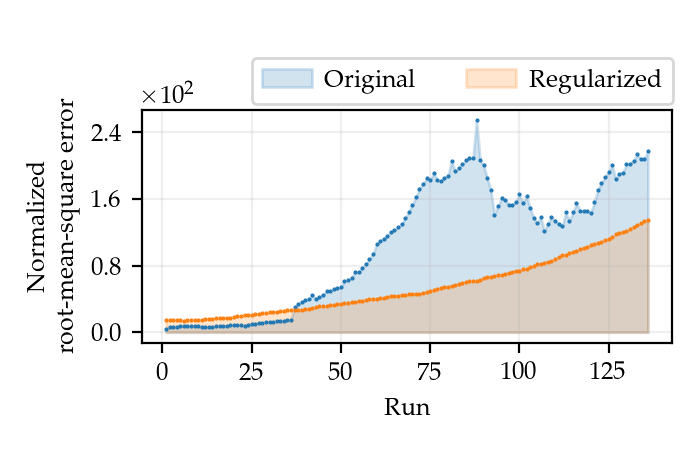

In [49]:
rmse_values_original_var = np.zeros(n_runs)
rmse_values_reg_var = np.zeros(n_runs)

for p, num_data_calibration in enumerate(np.arange(min_calibration_data, max_calibration_data, step_calibration_data)):
    for data_type in data_types:
        test_data = np.cumsum(original_data[:, num_data_calibration :
                                                      (num_data_calibration + num_days_prediction)], axis=1)
        if data_type == "original":
            test_simulation = np.zeros_like(test_data)
            test_simulation[0] = (infected_original_var_cumsum[p])[num_data_calibration :
                                                                (num_data_calibration + num_days_prediction)]
            test_simulation[1] = (dead_original_var_cumsum[p])[num_data_calibration :
                                                            (num_data_calibration + num_days_prediction)]
            rmse_values_original_var[p] = calc_rmse(test_data, test_simulation, num_days_prediction)
        elif data_type == "reg":
            test_simulation = np.zeros_like(test_data)
            test_simulation[0] = (infected_reg_var_cumsum[p])[num_data_calibration :
                                                                (num_data_calibration + num_days_prediction)]
            test_simulation[1] = (dead_reg_var_cumsum[p])[num_data_calibration :
                                                            (num_data_calibration + num_days_prediction)]
            
            rmse_values_reg_var[p] = calc_rmse(test_data, test_simulation, num_days_prediction)
            
area_rmse_original_var = simps(rmse_values_original_var, dx=1e-1)
area_rmse_reg_var = simps(rmse_values_reg_var, dx=1e-1)

print("RMSE reduction on average: %.3f %%" %((1 - (area_rmse_reg_var / area_rmse_original_var)) * 100))
print("Runs with lower RMSE: %.3f %%" %((float(np.size(np.where(rmse_values_reg_var < rmse_values_original_var))) /
                                         float(n_runs)) * 100))
print("Original data: A = %.2f u. a.\nRegularized data: A = %.2f u. a." %(area_rmse_original_var, area_rmse_reg_var))

idx_max_diff_rmse_var = int((np.where(np.abs(rmse_values_original_var -
                                rmse_values_reg_var) == np.max(np.abs(rmse_values_original_var -
                                                                  rmse_values_reg_var))))[0])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.25))

ax.fill_between(
    array_n_runs,
    rmse_values_original_var,
    linestyle="-",
    linewidth=1,
    color=original_data_color,
    alpha=0.2,
    label="Original",
)

ax.fill_between(
    array_n_runs,
    rmse_values_reg_var,
    linestyle="-",
    linewidth=1,
    color=reg_data_color,
    alpha=0.2,
    label="Regularized",
)

ax.plot(
    array_n_runs,
    rmse_values_original_var,
    linestyle="",
    linewidth=0,
    marker="o",
    markersize=0.5,
    alpha=1
)

ax.plot(
    array_n_runs,
    rmse_values_reg_var,
    linestyle="",
    linewidth=0,
    marker="o",
    markersize=0.5,
    alpha=1
)

ax.grid(alpha=0.2)

ax.set_xlabel("Run")
ax.set_ylabel("Normalized\nroot-mean-square error")

ax.ticklabel_format(axis='y', useOffset=True, scilimits=(0,0))
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ax.legend(loc="upper right", fontsize=fontsize, ncol=2, handletextpad=0.5, bbox_to_anchor=(1.025,1.275))

fig.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/" + "RMSE_var" + ".pdf")